<span style="color:blue; font-size:22pt"> <ins>**Project: Moving Challenge:**</ins></span>

<h4 align=justify>  I am attempting to use available datasets in conjunction with Foursquare and Google API's to determine the best place to move. I am using location data from my four favorite neighborhoods in my four favorite cities:<br> <ol> 1) La Jolla,an Diego, CA</ol> <ol>2) West Palm Beach, FL</ol> <ol>3) Downtown Chicago</ol> <ol>4) Portland, Maine</ol> I want to find the venues that best characterize a location combining attributes of each location with Foursquare.<br>
    I will cluster the data from:<br> <ol>1) Dallas, TX</ol> <ol>2) Jacksonville, FL</ol> <ol>3) Chicago, IL</ol> <ol>4) Austin, TX</ol> <ol>5) San Diego, CA</ol> I will find the neighborhoods most like my ideal match using SciKitlearn KMeans Clustering of Foursquare data. Next, a further segmentation by demographics, job availability, and income gathered from website and census data will help me choose my ideal neghborhood.  </h4>

<span style="color:green;font-size:20pt"> <ins>Data Collection:</ins></span>

<h4 align="justify"> <ins>First I will gather the neighborhood names from a variety of websites including:</ins>
<ol><a href="http://www.Wikipedia.com" target = _blank>Wikipedia.com</a></ol>
<ol><a href="http://www.Conservapedia.com" target = _blank>Conservapedia.com</a></ol><br>
I will parse them using a combination of pandas.read_html, BeautifulSoup, requests, and json.</h4>

In [203]:
#import modules and set pandas configuration
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

#Webscraoping modules from obtaining data from the web
import re
import requests
from bs4 import BeautifulSoup

#module to handle json requests and importation into pandas dataframe
import json
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')


Libraries imported.


In [2]:
#load API keys for Foursqaure and Google Geolaction API from local file for security
with open(r'api_key.txt', 'r') as file:
    api_key = file.readline()
    CLIENT_ID = file.readline()
    CLIENT_SECRET = file.readline()
VERSION = '20180605' # Foursquare API version


<span style="font-size:16pt; color:red"><ins>San Diego, CA:</ins></span><br>
<span style="font-size:14pt; color:black">Neighborhood list</span>

In [3]:
#url for a list of neighborhoods in San Diego
url_sandiego = r'https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego'


In [359]:
#Using Beautiful Soup, extract neighborhood list from table(pd.read_html failed) and create a 
#neighborhood data frame

#Find all divs with sepcific style to obtain names
url_string=r'https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego'
page=requests.get(url_string)
page=page.text
soup=BeautifulSoup(page,features="html.parser")
results=soup.find_all("div", attrs={'style':'padding:0em 0.25em'})
neighborhood_list = []

for items in results:
    neighborhood_list.append(items.text.strip().split('\n'))  #split on newline
    
neighborhood_list = neighborhood_list[:-2]                    #remove uneeded information from list
neighborhood_list_2 = []

neighborhood_list_2 = [item for items in neighborhood_list for item in items]  #extract each item in row of list
        
sandiego_neighborhoods = pd.DataFrame(neighborhood_list_2, columns = ['Neighborhood']) #create dataframe

sandiego_neighborhoods['Neighborhood']=sandiego_neighborhoods['Neighborhood'].map(     #add city and State to name
    lambda x: x  + ', San Diego'  + ', CA')

sandiego_neighborhoods.head()


,Neighborhood
0,"Bay Ho, San Diego, CA"
1,"Bay Park, San Diego, CA"
2,"Carmel Valley, San Diego, CA"
3,"Clairemont, San Diego, CA"
4,"Del Mar Heights, San Diego, CA"


<span style="font-size:16pt; color:red"><ins>Austin, TX:</ins></span><br>
<span style="font-size:14pt; color:black">Neighborhood list</span>

In [12]:
url_austin = r'https://en.wikipedia.org/wiki/List_of_Austin_neighborhoods'


In [13]:
table_austin = pd.read_html(url_austin)
table_austin = table_austin[0]
table_austin.drop(['COA ID#[nb 1]'], axis=1, inplace = True)
austin_neighborhoods = table_austin
austin_neighborhoods.rename(columns={'Name':'Neighborhood'}, inplace=True)
austin_neighborhoods['Neighborhood'] = austin_neighborhoods['Neighborhood'].map(lambda x: x +', Austin, '+ 'TX')
austin_neighborhoods.head()


,Neighborhood
0,"Bryker Woods, Austin, TX"
1,"Caswell Heights, Austin, TX"
2,"Downtown Austin, Austin, TX"
3,"Eastwoods, Austin, TX"
4,"Hancock, Austin, TX"


<span style="font-size:16pt; color:red"><ins>Dallas, TX:</ins></span><br>
<span style="font-size:14pt; color:black">Neighborhood list</span>

In [14]:
url_dallas = r'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Dallas'


In [15]:
#Reptition of above for Austin
table_dallas = pd.read_html(url_dallas)
table_dallas_concat = pd.DataFrame(columns=["Neighborhood"])
for i in range(1, len(table_dallas)):
    temp_table = pd.DataFrame(table_dallas[i].iloc[:,1])
    temp_table.rename(columns={temp_table.columns[0]:"Neighborhood"}, inplace=True)
    table_dallas_concat = table_dallas_concat.append(temp_table, ignore_index=True)
    temp_table = []
dallas_neighborhoods = table_dallas_concat


In [16]:
def remove_website_str(x):
    """Remove website from city names"""
    if x.startswith('website'):
        x = x.split()
        x=' '.join(x[1:])
    return x

In [18]:
#Remove website string
dallas_neighborhood_clean = dallas_neighborhoods['Neighborhood'].apply(remove_website_str)
dallas_neighborhood_clean = pd.DataFrame(dallas_neighborhood_clean, columns = ['Neighborhood'])
#Remove uneeded rows from dataframe
dallas_neighborhood_clean.drop(index=[205, 206, 207, 208, 209], inplace = True)
#Add City and State
dallas_neighborhood_clean['Neighborhood'] = dallas_neighborhood_clean['Neighborhood'].map(
    lambda x: x +', Dallas, '+ 'TX')
dallas_neighborhood_clean.head()


,Neighborhood
0,"Baylor District, Dallas, TX"
1,"The Cedars, Dallas, TX"
2,"Civic Center District, Dallas, TX"
3,"Dallas Arts District, Dallas, TX"
4,"Dallas Farmers Market, Dallas, TX"


<span style="font-size:16pt; color:red"><ins>Chicago, IL:</ins></span><br>
<span style="font-size:14pt; color:black">Neighborhood list</span>

In [20]:
url_chicago = r'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago'


In [21]:
#Reptition of Austin --webscrape Wikipedia Table
table_chicago = pd.read_html(url_chicago)
table_chicago = table_chicago[0]
table_chicago.drop(['Community area'], axis=1, inplace=True)
chicago_neighborhoods = table_chicago
chicago_neighborhoods['Neighborhood'] = chicago_neighborhoods['Neighborhood'].map(lambda x: x +', Chicago, '+ 'IL')
chicago_neighborhoods.head()


,Neighborhood
0,"Albany Park, Chicago, IL"
1,"Altgeld Gardens, Chicago, IL"
2,"Andersonville, Chicago, IL"
3,"Archer Heights, Chicago, IL"
4,"Armour Square, Chicago, IL"


<span style="font-size:16pt; color:red"><ins>Jacksonville, FL:</ins></span><br>
<span style="font-size:14pt; color:black">Neighborhood list</span>

In [22]:
jacksonville_neighborhoods = pd.DataFrame(columns=['Neighborhood'])  #Create empty dataframe
#USe consevapedia -- wikipedia no neghborhood data
url_string=r'https://www.conservapedia.com/Neighborhoods_of_Jacksonville,_Florida'


In [23]:
page=requests.get(url_string)
page=page.text
soup=BeautifulSoup(page,features="html.parser")
results=soup.find_all("li", class_="toclevel-2")     #find all lists with specific class
for index, item in enumerate(results):
    area = item.find("span", class_="toctext").text  #extract specific elements from list and append data
    jacksonville_neighborhoods = jacksonville_neighborhoods.append({'Neighborhood':area}, ignore_index=True) 
jacksonville_neighborhoods['Neighborhood'] = jacksonville_neighborhoods['Neighborhood'].map(lambda x: x +', Jacksonville, '+ 'FL')
jacksonville_neighborhoods.head()


,Neighborhood
0,"Argyle, Jacksonville, FL"
1,"Avondale, Jacksonville, FL"
2,"Cedar Hills, Jacksonville, FL"
3,"Confederate Point, Jacksonville, FL"
4,"Lake Shore, Jacksonville, FL"


<h2 align=justify style="color:green"> <ins>Obtaining Longitude, Latitude, Zipcode from Goodle API</ins></h2>
    <h3>
    I will obtain them using a custom functions fro json extraction</h3>

In [33]:
#function to only append one returned value for longitude and latitude
def get_lng_lat_zip(neighborhoods):
    """Using Google API, request longtiude and latitude by neighborhood name"""
    location_lng_lat = []
    for i in range(len(neighborhoods)):
        url = r'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(neighborhoods['Neighborhood'][i], api_key)
        r = requests.get(url)
        json_r = json.loads(r.text)
        #build data frame from returned data only using firts returned value
        location_pd = json_normalize(json_r['results'])
        location_lng_lat_temp =  (location_pd[['geometry.location.lat', 'geometry.location.lng']])
        location_lng_lat.append([(location_lng_lat_temp.iloc[0,:])[0], (location_lng_lat_temp.iloc[0,:])[1]])
            
    return location_lng_lat 


In [54]:
def zip_nb(neighborhoods):
    """Request zip code by longitude and latitude data"""
    zip_pd_temp = []
    for i in range(len(neighborhoods)):
        #try except loop if no value is returned
        try: 
            url_2 = 'https://maps.googleapis.com/maps/api/geocode/json?latlng={},{}&key={}'.format(neighborhoods['Latitude'][i], neighborhoods['Longitude'][i],api_key)
            r = requests.get(url_2)
            json_r = json.loads(r.text)
            #normalize specific section of returned json onject
            location_pd_3 = json_normalize(json_r['results'][0]['address_components'])
            count=0
            #check for value in zip code data -- if none add NA

            for line in location_pd_3.values:
                if 'postal_code' in line[2]:
                    zip_code = line[0]
                    count=1
                if count != 1:
                    zip_code = 'NA'
            zip_pd_temp.append(zip_code)
            count=0
        except IndexError:
            zip_code = 'NA'
            zip_pd_temp.append(zip_code)
            count=0
    zip_pd = pd.DataFrame(zip_pd_temp, columns = ['zip_code'])
    return(zip_pd) 


<span style="font-size:16pt; color:red"><ins>San Diego, CA:</ins></span><br>
<span style="font-size:14pt; color:black">Latitude, Longitude, Zipcode</span>

In [43]:
sandiego_neighborhoods_zip = get_lng_lat_zip(sandiego_neighborhoods)   #run zipcode function
sandiego_neighborhoods_zip = pd.DataFrame(sandiego_neighborhoods_zip, columns=['Latitude', 'Longitude'])
sandiego_nb_lng_lat = pd.concat([sandiego_neighborhoods,               #creat dataframe with lng and lat data
                                    sandiego_neighborhoods_zip],
                                   axis=1)
sandiego_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,"Bay Ho, San Diego, CA",32.824243,-117.217637
1,"Bay Park, San Diego, CA",32.791837,-117.199996
2,"Carmel Valley, San Diego, CA",32.939827,-117.202936
3,"Clairemont, San Diego, CA",32.824140,-117.193697
4,"Del Mar Heights, San Diego, CA",32.948378,-117.260870


In [46]:
sandiego_zip_pd = zip_nb(sandiego_nb_lng_lat)              #Run Zip code function 
sandiego_zip_lng_lat = pd.concat([sandiego_nb_lng_lat,     #Append results to neghborhood dataframe
                                     sandiego_zip_pd],
                                    axis=1)
sandiego_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,92117
1,"Bay Park, San Diego, CA",32.791837,-117.199996,92117
2,"Carmel Valley, San Diego, CA",32.939827,-117.202936,92130
3,"Clairemont, San Diego, CA",32.824140,-117.193697,92117
4,"Del Mar Heights, San Diego, CA",32.948378,-117.260870,92014


In [109]:
#Remove any rows without zip code
sandiego_filter = sandiego_zip_lng_lat['zip_code'].apply(lambda x: x != 'NA')
sandiego_zip_lng_lat=sandiego_zip_lng_lat[sandiego_filter]
sandiego_zip_lng_lat.head()

,Neighborhood,Latitude,Longitude,zip_code
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,92117
1,"Bay Park, San Diego, CA",32.791837,-117.199996,92117
2,"Carmel Valley, San Diego, CA",32.939827,-117.202936,92130
3,"Clairemont, San Diego, CA",32.824140,-117.193697,92117
4,"Del Mar Heights, San Diego, CA",32.948378,-117.260870,92014


In [110]:
#reset indices
sandiego_zip_lng_lat = sandiego_zip_lng_lat.reset_index(drop=True)
sandiego_zip_lng_lat.head()

,Neighborhood,Latitude,Longitude,zip_code
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,92117
1,"Bay Park, San Diego, CA",32.791837,-117.199996,92117
2,"Carmel Valley, San Diego, CA",32.939827,-117.202936,92130
3,"Clairemont, San Diego, CA",32.824140,-117.193697,92117
4,"Del Mar Heights, San Diego, CA",32.948378,-117.260870,92014


<span style="font-size:16pt; color:red"><ins>Austin, TX:</ins></span><br>
<span style="font-size:14pt; color:black">Latitude, Longitude, Zipcode</span>

In [47]:
#Repeat as above for San Diego
austin_neighborhoods_zip = get_lng_lat_zip(austin_neighborhoods)   #run zipcode function
austin_neighborhoods_zip = pd.DataFrame(austin_neighborhoods_zip, columns=['Latitude', 'Longitude'])
austin_nb_lng_lat = pd.concat([austin_neighborhoods,               #creat dataframe with lng and lat data
                                    austin_neighborhoods_zip],
                                   axis=1)
austin_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,"Bryker Woods, Austin, TX",30.302450,-97.753893
1,"Caswell Heights, Austin, TX",30.307765,-97.719435
2,"Downtown Austin, Austin, TX",30.272921,-97.744386
3,"Eastwoods, Austin, TX",30.290371,-97.726479
4,"Hancock, Austin, TX",30.296469,-97.723215


In [48]:
#Repeat as above for San Diego
austin_zip_pd = zip_nb(austin_nb_lng_lat)
austin_zip_lng_lat = pd.concat([austin_nb_lng_lat,
                                     austin_zip_pd],
                                    axis=1)
austin_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
0,"Bryker Woods, Austin, TX",30.302450,-97.753893,78703
1,"Caswell Heights, Austin, TX",30.307765,-97.719435,78751
2,"Downtown Austin, Austin, TX",30.272921,-97.744386,78701
3,"Eastwoods, Austin, TX",30.290371,-97.726479,78705
4,"Hancock, Austin, TX",30.296469,-97.723215,78705


In [108]:
#reset indices
austin_zip_lng_lat = austin_zip_lng_lat.reset_index(drop=True)
austin_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
0,"Bryker Woods, Austin, TX",30.302450,-97.753893,78703
1,"Caswell Heights, Austin, TX",30.307765,-97.719435,78751
2,"Downtown Austin, Austin, TX",30.272921,-97.744386,78701
3,"Eastwoods, Austin, TX",30.290371,-97.726479,78705
4,"Hancock, Austin, TX",30.296469,-97.723215,78705


<span style="font-size:16pt; color:red"><ins>Dallas, TX:</ins></span><br>
<span style="font-size:14pt; color:black">Latitude, Longitude, Zipcode</span>

In [51]:
#Repeat as above -- see San Diego for details
dallas_neighborhoods_zip = get_lng_lat_zip(dallas_neighborhood_clean)   #run zipcode function
dallas_neighborhoods_zip = pd.DataFrame(dallas_neighborhoods_zip, columns=['Latitude', 'Longitude'])
dallas_nb_lng_lat = pd.concat([dallas_neighborhoods,               #creat dataframe with lng and lat data
                                    dallas_neighborhoods_zip],
                                   axis=1)
dallas_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,Baylor District,32.789342,-96.779515
1,The Cedars,32.765124,-96.789371
2,Civic Center District,32.774389,-96.800285
3,Dallas Arts District,32.789731,-96.798262
4,Dallas Farmers Market,32.777495,-96.789263


In [57]:
dallas_nb_lng_lat = pd.concat([dallas_neighborhood_clean,               #create dataframe with lng and lat data
                                    dallas_neighborhoods_zip],
                                   axis=1)
dallas_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,"Baylor District, Dallas, TX",32.789342,-96.779515
1,"The Cedars, Dallas, TX",32.765124,-96.789371
2,"Civic Center District, Dallas, TX",32.774389,-96.800285
3,"Dallas Arts District, Dallas, TX",32.789731,-96.798262
4,"Dallas Farmers Market, Dallas, TX",32.777495,-96.789263


In [58]:
#Same as above -- see San Diego for details
dallas_zip_pd = zip_nb(dallas_nb_lng_lat)
dallas_zip_lng_lat = pd.concat([dallas_nb_lng_lat,
                                     dallas_zip_pd],
                                    axis=1)
dallas_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
0,"Baylor District, Dallas, TX",32.789342,-96.779515,75246
1,"The Cedars, Dallas, TX",32.765124,-96.789371,75215
2,"Civic Center District, Dallas, TX",32.774389,-96.800285,75202
3,"Dallas Arts District, Dallas, TX",32.789731,-96.798262,75201
4,"Dallas Farmers Market, Dallas, TX",32.777495,-96.789263,75201


In [107]:
#reset indices
dallas_zip_lng_lat=dallas_zip_lng_lat.reset_index(drop=True)
dallas_zip_lng_lat.head()

,Neighborhood,Latitude,Longitude,zip_code
0,"Baylor District, Dallas, TX",32.789342,-96.779515,75246
1,"The Cedars, Dallas, TX",32.765124,-96.789371,75215
2,"Civic Center District, Dallas, TX",32.774389,-96.800285,75202
3,"Dallas Arts District, Dallas, TX",32.789731,-96.798262,75201
4,"Dallas Farmers Market, Dallas, TX",32.777495,-96.789263,75201


<span style="font-size:16pt; color:red"><ins>Chicago, IL:</ins></span><br>
<span style="font-size:14pt; color:black">Latitude, Longitude, Zipcode</span>

In [60]:
#Repeat as above for San Diego -- see San Diego
chicago_neighborhoods_zip = get_lng_lat_zip(chicago_neighborhoods)   #run zipcode function
chicago_neighborhoods_zip = pd.DataFrame(chicago_neighborhoods_zip, columns=['Latitude', 'Longitude'])
chicago_nb_lng_lat = pd.concat([chicago_neighborhoods,               #creat dataframe with lng and lat data
                                    chicago_neighborhoods_zip],
                                   axis=1)
chicago_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,"Albany Park, Chicago, IL",41.968327,-87.728028
1,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686
2,"Andersonville, Chicago, IL",41.979572,-87.670077
3,"Archer Heights, Chicago, IL",41.807900,-87.723585
4,"Armour Square, Chicago, IL",41.840755,-87.634019


In [73]:
#Repeat as above for San Diego -- see San Diego
chicago_zip_pd = zip_nb(chicago_nb_lng_lat)
chicago_zip_lng_lat = pd.concat([chicago_nb_lng_lat,
                                     chicago_zip_pd],
                                    axis=1)
#Remove any rows without zip code
chicago_filter = chicago_zip_lng_lat['zip_code'].apply(lambda x: x != 'NA')
chicago_zip_lng_lat=chicago_zip_lng_lat[chicago_filter].reset_index(drop=True)
chicago_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
1,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,60827
2,"Andersonville, Chicago, IL",41.979572,-87.670077,60640
3,"Archer Heights, Chicago, IL",41.807900,-87.723585,60632
4,"Armour Square, Chicago, IL",41.840755,-87.634019,60616
5,"Ashburn, Chicago, IL",41.749690,-87.712007,60652


In [106]:
#reset indices
chicago_zip_lng_lat=chicago_zip_lng_lat.reset_index(drop=True)
chicago_zip_lng_lat.head()

,Neighborhood,Latitude,Longitude,zip_code
0,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,60827
1,"Andersonville, Chicago, IL",41.979572,-87.670077,60640
2,"Archer Heights, Chicago, IL",41.807900,-87.723585,60632
3,"Armour Square, Chicago, IL",41.840755,-87.634019,60616
4,"Ashburn, Chicago, IL",41.749690,-87.712007,60652


<span style="font-size:16pt; color:red"><ins>Jacksonville, FL:</ins></span><br>
<span style="font-size:14pt; color:black">Latitude, Longitude, Zipcode</span>

In [62]:
#Repeat as above for San Diego -- See San Diego
jacksonville_neighborhoods_zip = get_lng_lat_zip(jacksonville_neighborhoods)   #run zipcode function
jacksonville_neighborhoods_zip = pd.DataFrame(jacksonville_neighborhoods_zip, columns=['Latitude', 'Longitude'])
jacksonville_nb_lng_lat = pd.concat([jacksonville_neighborhoods,               #creat dataframe with lng and lat data
                                    jacksonville_neighborhoods_zip],
                                   axis=1)
jacksonville_nb_lng_lat.head()


,Neighborhood,Latitude,Longitude
0,"Argyle, Jacksonville, FL",30.196921,-81.756282
1,"Avondale, Jacksonville, FL",30.296769,-81.710315
2,"Cedar Hills, Jacksonville, FL",30.253614,-81.756138
3,"Confederate Point, Jacksonville, FL",30.256893,-81.736310
4,"Lake Shore, Jacksonville, FL",30.280630,-81.726734


In [63]:
#Repeat as above for San Diego -- See San Diego
jacksonville_zip_pd = zip_nb(jacksonville_nb_lng_lat)
jacksonville_zip_lng_lat = pd.concat([jacksonville_nb_lng_lat,
                                     jacksonville_zip_pd],
                                    axis=1)
jacksonville_zip_lng_lat.head()


,Neighborhood,Latitude,Longitude,zip_code
0,"Argyle, Jacksonville, FL",30.196921,-81.756282,32244
1,"Avondale, Jacksonville, FL",30.296769,-81.710315,32205
2,"Cedar Hills, Jacksonville, FL",30.253614,-81.756138,32210
3,"Confederate Point, Jacksonville, FL",30.256893,-81.736310,32210
4,"Lake Shore, Jacksonville, FL",30.280630,-81.726734,32210


In [111]:
#reset indices
jacksonville_zip_lng_lat = jacksonville_zip_lng_lat.reset_index(drop=True)
jacksonville_zip_lng_lat.head()

,Neighborhood,Latitude,Longitude,zip_code
0,"Argyle, Jacksonville, FL",30.196921,-81.756282,32244
1,"Avondale, Jacksonville, FL",30.296769,-81.710315,32205
2,"Cedar Hills, Jacksonville, FL",30.253614,-81.756138,32210
3,"Confederate Point, Jacksonville, FL",30.256893,-81.736310,32210
4,"Lake Shore, Jacksonville, FL",30.280630,-81.726734,32210


<h2 align=justify style="color:green"> <ins>Obtaining Demographic Data By Zipcode for each Neighborhood</ins></h2>
    <h3>
    I will obtain them using a custom functions from <a href="http://www.zipwho.com" target = _blank>ZipWho.com<a></h3>

In [358]:
#Function to extract data from zipwho.com
def zip_demographics(neighborhood_zip):
    """Function extracts data from zipwho. Firefox emulation to retrieve data. Tra and except for zip codes
    with no current data. Extract data from result string with string manipulation and list manipulation"""
    zip_list = []
    zip_list_nan = ['N/A' for i in range(37)]  #add N/A for all 37 demographic entries
    for i in range(len(neighborhood_zip)):
        url_zip = 'https://zipwho.com/?zip={}-&city=&filters=--_--_--_--&state=&mode=zip'.format(neighborhood_zip['zip_code'][i])
        #emulate Firefox to avoid dread 403 Forbidden
        headers ={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:68.0) Gecko/20100101 Firefox/68.0'}
        page=requests.get(url_zip, headers=headers)                 #Creat soup with requests and BS4
        page=page.text
        soup=BeautifulSoup(page,features="html.parser")
        start_index = str(soup.contents[4]).index('return')
        end_index = str(soup.contents[4]).index('}')
        #if no data present append N/A list
        try:
            string_data = str(soup.contents[4])[start_index+8:end_index-4]
            string_data_split = string_data.split('\\n')
            data = string_data_split[1].split(',')
            numbers = string_data_split[0].split(',')
            zip_list.append(data)
        except IndexError:
            zip_list.append(zip_list_nan)
    zip_list_pd = pd.DataFrame(zip_list, columns = numbers)
    zip_list_pd.rename(columns ={'zip':'zip_code'}, inplace = True)
    zip_list_pd.drop(columns=['city', 'state'], inplace=True)
    return zip_list_pd


<span style="font-size:16pt; color:red"><ins>San Diego, CA:</ins></span><br>
<span style="font-size:14pt; color:black">Demographic Data</span>

In [116]:
#get demographics with zip code data
sandiego_zip_list = zip_demographics(sandiego_zip_lng_lat)
sandiego_zip_list.head()


,zip_code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
1,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
2,92130,93929,98,491.3,98,25.0,90,77.1,50,6.1,81,72.9,99,70.4,99,28172,84,2.6,60,35.9,37,89.2,33,65.5,76,9.6,53,76.1,30,0.7,39,13.9,97,5.9,73
3,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
4,92014,97029,98,748.5,99,25.2,90,72.3,35,5.9,73,71.3,99,68.5,99,14084,65,2.2,7,44.4,95,95.8,68,60.5,45,13.1,91,88.2,48,1.0,44,4.4,89,4.1,67


In [121]:
#Merged dataframes with all current data and rename columns
sandiego_data_merged = pd.merge(sandiego_zip_lng_lat, sandiego_zip_list, right_index=True, left_index=True)
sandiego_data_merged = sandiego_data_merged.drop('zip_code_y', axis=1)
sandiego_data_merged.rename(columns={'zip_code_x':'Zip Code'}, inplace=True)
sandiego_data_merged.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
1,"Bay Park, San Diego, CA",32.791837,-117.199996,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
2,"Carmel Valley, San Diego, CA",32.939827,-117.202936,92130,93929,98,491.3,98,25.0,90,77.1,50,6.1,81,72.9,99,70.4,99,28172,84,2.6,60,35.9,37,89.2,33,65.5,76,9.6,53,76.1,30,0.7,39,13.9,97,5.9,73
3,"Clairemont, San Diego, CA",32.824140,-117.193697,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
4,"Del Mar Heights, San Diego, CA",32.948378,-117.260870,92014,97029,98,748.5,99,25.2,90,72.3,35,5.9,73,71.3,99,68.5,99,14084,65,2.2,7,44.4,95,95.8,68,60.5,45,13.1,91,88.2,48,1.0,44,4.4,89,4.1,67


In [139]:
#Remove data with no demographics available
sandiego_filter = sandiego_data_merged['MedianIncome'].apply(lambda x: x != 'N/A')
sandiego_filtered=sandiego_data_merged[sandiego_filter]
#remove neighborhoods in same zip with same demographics keeping first listed
sandiego_filtered.drop_duplicates(subset=['Zip Code'], keep='first', inplace=True)
sandiego_filtered.reset_index(drop=True, inplace=True)
sandiego_filtered.head()


C:\Users\gtm12\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,92117,47245,71,241.2,91,26.1,93,58.9,14,5.0,16,31.2,81,41.3,84,51197,97,2.4,29,37.7,57,93.2,55,52.2,16,11.5,78,69.3,24,1.6,51,9.0,95,15.7,87
1,"Carmel Valley, San Diego, CA",32.939827,-117.202936,92130,93929,98,491.3,98,25.0,90,77.1,50,6.1,81,72.9,99,70.4,99,28172,84,2.6,60,35.9,37,89.2,33,65.5,76,9.6,53,76.1,30,0.7,39,13.9,97,5.9,73
2,"Del Mar Heights, San Diego, CA",32.948378,-117.260870,92014,97029,98,748.5,99,25.2,90,72.3,35,5.9,73,71.3,99,68.5,99,14084,65,2.2,7,44.4,95,95.8,68,60.5,45,13.1,91,88.2,48,1.0,44,4.4,89,4.1,67
3,"La Jolla, San Diego, CA",32.832811,-117.271272,92037,68691,92,682.8,99,26.4,94,61.1,16,5.1,21,67.7,99,63.8,98,42826,95,2.4,29,38.4,64,90.8,42,48.1,10,9.4,49,77.9,32,0.7,39,11.2,96,7.1,76
4,"Mission Beach, San Diego, CA",32.770653,-117.251445,92109,45202,66,373.7,97,29.2,98,29.8,2,3.7,2,50.8,94,48.1,91,45834,96,1.9,1,30.9,9,122.6,97,30.7,0,10.9,71,81.5,36,1.3,48,3.0,85,10.3,82


In [157]:
#Remove all columns including 'Rank' as they are unnecessary with other data included
col_list = sandiego_filtered.columns
new_col_list = []
for col in col_list:
    if 'Rank' not in col:
        new_col_list.append(col)
sandiego_filtered = sandiego_filtered[new_col_list]
sandiego_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,CostOfLivingIndex,MedianMortgageToIncomeRatio,OwnerOccupiedHomesPercent,MedianRoomsInHome,CollegeDegreePercent,ProfessionalPercent,Population,AverageHouseholdSize,MedianAge,MaleToFemaleRatio,MarriedPercent,DivorcedPercent,WhitePercent,BlackPercent,AsianPercent,HispanicEthnicityPercent
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,92117,47245,241.2,26.1,58.9,5.0,31.2,41.3,51197,2.4,37.7,93.2,52.2,11.5,69.3,1.6,9.0,15.7
1,"Carmel Valley, San Diego, CA",32.939827,-117.202936,92130,93929,491.3,25.0,77.1,6.1,72.9,70.4,28172,2.6,35.9,89.2,65.5,9.6,76.1,0.7,13.9,5.9
2,"Del Mar Heights, San Diego, CA",32.948378,-117.260870,92014,97029,748.5,25.2,72.3,5.9,71.3,68.5,14084,2.2,44.4,95.8,60.5,13.1,88.2,1.0,4.4,4.1
3,"La Jolla, San Diego, CA",32.832811,-117.271272,92037,68691,682.8,26.4,61.1,5.1,67.7,63.8,42826,2.4,38.4,90.8,48.1,9.4,77.9,0.7,11.2,7.1
4,"Mission Beach, San Diego, CA",32.770653,-117.251445,92109,45202,373.7,29.2,29.8,3.7,50.8,48.1,45834,1.9,30.9,122.6,30.7,10.9,81.5,1.3,3.0,10.3


In [158]:
#save to csv for later use
sandiego_filtered.to_csv('sandiego_filtered.csv')


<span style="font-size:16pt; color:red"><ins>Austin, TX:</ins></span><br>
<span style="font-size:14pt; color:black">Demographic Data</span>

In [113]:
#get demographics with zip code data
austin_zip_list = zip_demographics(austin_zip_lng_lat)
austin_zip_list.head()

,zip_code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,78703,54591,81,326.0,96,21.1,50,51.5,8,4.8,10,74.1,99,68.1,99,19522,73,2.0,2,34.5,25,97.7,75,50.4,13,9.7,54,81.7,36,1.5,50,6.8,93,7.6,77
1,78751,29779,18,160.5,78,23.5,80,25.9,1,3.6,1,55.3,96,49.7,92,13829,64,1.8,0,28.1,3,122.2,97,27.6,0,10.4,64,67.3,22,1.5,50,6.8,93,21.6,90
2,78701,35757,40,199.8,87,23.9,83,37.7,4,3.3,1,46.2,92,48.9,92,3780,30,2.2,6,36.1,39,180.6,99,32.8,1,14.0,94,66.8,22,9.8,76,4.4,90,15.4,87
3,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82
4,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82


In [130]:
#Merged dataframes with all current data and rename columns
austin_data_merged = pd.merge(austin_zip_lng_lat, austin_zip_list, right_index=True, left_index=True)
austin_data_merged = austin_data_merged.drop('zip_code_y', axis=1)
austin_data_merged.rename(columns={'zip_code_x':'Zip Code'}, inplace=True)
austin_data_merged.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bryker Woods, Austin, TX",30.302450,-97.753893,78703,54591,81,326.0,96,21.1,50,51.5,8,4.8,10,74.1,99,68.1,99,19522,73,2.0,2,34.5,25,97.7,75,50.4,13,9.7,54,81.7,36,1.5,50,6.8,93,7.6,77
1,"Caswell Heights, Austin, TX",30.307765,-97.719435,78751,29779,18,160.5,78,23.5,80,25.9,1,3.6,1,55.3,96,49.7,92,13829,64,1.8,0,28.1,3,122.2,97,27.6,0,10.4,64,67.3,22,1.5,50,6.8,93,21.6,90
2,"Downtown Austin, Austin, TX",30.272921,-97.744386,78701,35757,40,199.8,87,23.9,83,37.7,4,3.3,1,46.2,92,48.9,92,3780,30,2.2,6,36.1,39,180.6,99,32.8,1,14.0,94,66.8,22,9.8,76,4.4,90,15.4,87
3,"Eastwoods, Austin, TX",30.290371,-97.726479,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82
4,"Hancock, Austin, TX",30.296469,-97.723215,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82


In [136]:
#Remove data with no demographics available
austin_filter = austin_data_merged['MedianIncome'].apply(lambda x: x != 'N/A')
austin_filtered = austin_data_merged[austin_filter]
#remove neighborhoods in same zip with same demographics keeping first listed
austin_filtered.drop_duplicates(subset=['Zip Code'], keep='first', inplace=True)
austin_filtered.reset_index(drop=True, inplace=True)
austin_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Bryker Woods, Austin, TX",30.302450,-97.753893,78703,54591,81,326.0,96,21.1,50,51.5,8,4.8,10,74.1,99,68.1,99,19522,73,2.0,2,34.5,25,97.7,75,50.4,13,9.7,54,81.7,36,1.5,50,6.8,93,7.6,77
1,"Caswell Heights, Austin, TX",30.307765,-97.719435,78751,29779,18,160.5,78,23.5,80,25.9,1,3.6,1,55.3,96,49.7,92,13829,64,1.8,0,28.1,3,122.2,97,27.6,0,10.4,64,67.3,22,1.5,50,6.8,93,21.6,90
2,"Downtown Austin, Austin, TX",30.272921,-97.744386,78701,35757,40,199.8,87,23.9,83,37.7,4,3.3,1,46.2,92,48.9,92,3780,30,2.2,6,36.1,39,180.6,99,32.8,1,14.0,94,66.8,22,9.8,76,4.4,90,15.4,87
3,"Eastwoods, Austin, TX",30.290371,-97.726479,78705,14740,0,185.5,84,21.5,56,11.0,0,2.8,0,73.0,99,45.8,89,26972,83,2.7,72,21.2,0,140.7,98,13.4,0,2.8,0,69.1,24,2.4,56,15.0,97,10.3,82
4,"Oakmont Heights, Austin, TX",30.311722,-97.754573,78731,62404,89,275.7,94,22.3,67,59.3,14,5.4,41,71.1,99,65.6,99,24068,80,2.0,2,37.4,54,94.6,63,51.7,15,9.7,54,84.9,41,0.8,41,6.1,92,6.7,75


In [159]:
#Remove all columns including 'Rank' as they are unnecessary with other data included
col_list = austin_filtered.columns
new_col_list = []
for col in col_list:
    if 'Rank' not in col:
        new_col_list.append(col)
austin_filtered = austin_filtered[new_col_list]
austin_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,CostOfLivingIndex,MedianMortgageToIncomeRatio,OwnerOccupiedHomesPercent,MedianRoomsInHome,CollegeDegreePercent,ProfessionalPercent,Population,AverageHouseholdSize,MedianAge,MaleToFemaleRatio,MarriedPercent,DivorcedPercent,WhitePercent,BlackPercent,AsianPercent,HispanicEthnicityPercent
0,"Bryker Woods, Austin, TX",30.302450,-97.753893,78703,54591,326.0,21.1,51.5,4.8,74.1,68.1,19522,2.0,34.5,97.7,50.4,9.7,81.7,1.5,6.8,7.6
1,"Caswell Heights, Austin, TX",30.307765,-97.719435,78751,29779,160.5,23.5,25.9,3.6,55.3,49.7,13829,1.8,28.1,122.2,27.6,10.4,67.3,1.5,6.8,21.6
2,"Downtown Austin, Austin, TX",30.272921,-97.744386,78701,35757,199.8,23.9,37.7,3.3,46.2,48.9,3780,2.2,36.1,180.6,32.8,14.0,66.8,9.8,4.4,15.4
3,"Eastwoods, Austin, TX",30.290371,-97.726479,78705,14740,185.5,21.5,11.0,2.8,73.0,45.8,26972,2.7,21.2,140.7,13.4,2.8,69.1,2.4,15.0,10.3
4,"Oakmont Heights, Austin, TX",30.311722,-97.754573,78731,62404,275.7,22.3,59.3,5.4,71.1,65.6,24068,2.0,37.4,94.6,51.7,9.7,84.9,0.8,6.1,6.7


In [160]:
#save to csv for later use
austin_filtered.to_csv('austin_filtered.csv')


<span style="font-size:16pt; color:red"><ins>Dallas, TX:</ins></span><br>
<span style="font-size:14pt; color:black">Demographic Data</span>

In [140]:
#get demographics with zip code data
dallas_zip_list = zip_demographics(dallas_zip_lng_lat)
dallas_zip_list.head()


,zip_code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,75246,21468,2,92.4,43,29.6,98,11.3,0,3.0,0,17.6,56,15.8,3,4686,36,3.1,92,32.5,14,128.6,98,43.6,6,6.5,12,27.8,6,12.6,79,1.6,75,55.9,97
1,75215,16043,0,39.4,1,25.9,93,33.6,3,4.3,4,6.4,5,17.7,6,18643,72,2.6,58,34.4,23,78.9,4,34.3,1,13.7,93,2.4,0,84.0,99,0.1,30,12.1,84
2,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77
4,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77


In [146]:
#Merged dataframes with all current data and rename columns
dallas_data_merged = pd.merge(dallas_zip_lng_lat, dallas_zip_list, right_index=True, left_index=True)
dallas_data_merged = dallas_data_merged.drop('zip_code_y', axis=1)
dallas_data_merged.rename(columns={'zip_code_x':'Zip Code'}, inplace=True)
dallas_data_merged.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Baylor District, Dallas, TX",32.789342,-96.779515,75246,21468,2,92.4,43,29.6,98,11.3,0,3.0,0,17.6,56,15.8,3,4686,36,3.1,92,32.5,14,128.6,98,43.6,6,6.5,12,27.8,6,12.6,79,1.6,75,55.9,97
1,"The Cedars, Dallas, TX",32.765124,-96.789371,75215,16043,0,39.4,1,25.9,93,33.6,3,4.3,4,6.4,5,17.7,6,18643,72,2.6,58,34.4,23,78.9,4,34.3,1,13.7,93,2.4,0,84.0,99,0.1,30,12.1,84
2,"Civic Center District, Dallas, TX",32.774389,-96.800285,75202,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,"Dallas Arts District, Dallas, TX",32.789731,-96.798262,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77
4,"Dallas Farmers Market, Dallas, TX",32.777495,-96.789263,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77


In [145]:
#Remove data with no demographics available
dallas_filter = dallas_data_merged['MedianIncome'].apply(lambda x: x != 'N/A')
dallas_filtered = dallas_data_merged[dallas_filter]
#remove neighborhoods in same zip with same demographics keeping first listed
dallas_filtered.drop_duplicates(subset=['Zip Code'], keep='first', inplace=True)
dallas_filtered.reset_index(drop=True, inplace=True)
dallas_filtered.head()


C:\Users\gtm12\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Baylor District, Dallas, TX",32.789342,-96.779515,75246,21468,2,92.4,43,29.6,98,11.3,0,3.0,0,17.6,56,15.8,3,4686,36,3.1,92,32.5,14,128.6,98,43.6,6,6.5,12,27.8,6,12.6,79,1.6,75,55.9,97
1,"The Cedars, Dallas, TX",32.765124,-96.789371,75215,16043,0,39.4,1,25.9,93,33.6,3,4.3,4,6.4,5,17.7,6,18643,72,2.6,58,34.4,23,78.9,4,34.3,1,13.7,93,2.4,0,84.0,99,0.1,30,12.1,84
2,"Dallas Arts District, Dallas, TX",32.789731,-96.798262,75201,56675,84,311.3,95,15.6,0,10.8,0,3.3,1,63.5,98,66.1,99,3324,27,1.6,0,30.0,7,112.0,96,31.5,1,11.6,79,68.8,23,19.4,85,2.2,80,7.6,77
3,"Deep Ellum, Dallas, TX",32.784392,-96.780185,75226,38911,50,441.5,98,32.5,99,1.0,0,2.6,0,34.5,84,40.9,84,2693,20,2.5,33,29.6,6,184.3,99,45.2,7,9.0,43,37.8,8,11.4,78,1.8,77,48.5,96
4,"Thanksgiving Commercial Center, Dallas, TX",32.868538,-96.773511,75225,98838,98,485.0,98,21.0,49,76.9,49,6.8,94,74.9,99,66.0,99,20157,74,2.3,14,41.7,88,78.4,3,65.6,77,7.9,28,95.9,72,0.0,5,0.7,58,2.2,53


In [161]:
#Remove all columns including 'Rank' as they are unnecessary with other data included
col_list = dallas_filtered.columns
new_col_list = []
for col in col_list:
    if 'Rank' not in col:
        new_col_list.append(col)
dallas_filtered = dallas_filtered[new_col_list]
dallas_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,CostOfLivingIndex,MedianMortgageToIncomeRatio,OwnerOccupiedHomesPercent,MedianRoomsInHome,CollegeDegreePercent,ProfessionalPercent,Population,AverageHouseholdSize,MedianAge,MaleToFemaleRatio,MarriedPercent,DivorcedPercent,WhitePercent,BlackPercent,AsianPercent,HispanicEthnicityPercent
0,"Baylor District, Dallas, TX",32.789342,-96.779515,75246,21468,92.4,29.6,11.3,3.0,17.6,15.8,4686,3.1,32.5,128.6,43.6,6.5,27.8,12.6,1.6,55.9
1,"The Cedars, Dallas, TX",32.765124,-96.789371,75215,16043,39.4,25.9,33.6,4.3,6.4,17.7,18643,2.6,34.4,78.9,34.3,13.7,2.4,84.0,0.1,12.1
2,"Dallas Arts District, Dallas, TX",32.789731,-96.798262,75201,56675,311.3,15.6,10.8,3.3,63.5,66.1,3324,1.6,30.0,112.0,31.5,11.6,68.8,19.4,2.2,7.6
3,"Deep Ellum, Dallas, TX",32.784392,-96.780185,75226,38911,441.5,32.5,1.0,2.6,34.5,40.9,2693,2.5,29.6,184.3,45.2,9.0,37.8,11.4,1.8,48.5
4,"Thanksgiving Commercial Center, Dallas, TX",32.868538,-96.773511,75225,98838,485.0,21.0,76.9,6.8,74.9,66.0,20157,2.3,41.7,78.4,65.6,7.9,95.9,0.0,0.7,2.2


In [162]:
#save to csv for later use
dallas_filtered.to_csv('dallas_filtered.csv')

<span style="font-size:16pt; color:red"><ins>Chicago, IL:</ins></span><br>
<span style="font-size:14pt; color:black">Demographic Data</span>

In [117]:
#get demographics with zip code data
chicago_zip_list = zip_demographics(chicago_zip_lng_lat)
chicago_zip_list.head()


,zip_code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,60827,32118,26,93.3,44,22.2,65,48.5,7,4.9,12,9.9,20,21.6,19,33132,89,3.0,91,26.5,2,67.4,0,40.5,4,10.2,61,6.9,1,87.3,99,0.2,38,4.1,66
1,60640,32466,28,196.2,86,20.9,48,23.5,1,3.5,1,38.4,88,42.5,86,73786,99,2.0,2,34.6,25,100.8,85,38.1,3,10.0,58,42.4,10,19.1,84,12.9,97,21.5,90
2,60632,37406,46,139.5,71,24.1,84,58.1,13,4.8,11,7.0,7,12.5,0,87700,99,3.5,97,27.6,3,101.1,85,54.5,21,5.4,5,25.5,5,0.9,42,2.0,78,70.2,98
3,60616,30625,21,179.9,83,22.9,74,27.1,2,3.7,2,24.1,71,35.2,74,47259,96,2.4,29,34.1,22,80.8,6,45.9,7,9.6,52,21.5,4,38.6,92,28.1,99,9.2,80
4,60652,53120,80,130.1,67,23.8,82,90.9,95,5.5,55,19.3,61,29.1,55,38992,93,3.0,91,34.0,21,86.0,19,55.0,22,7.4,21,37.4,8,41.6,93,1.2,71,16.7,88


In [147]:
#Merged dataframes with all current data and rename columns
chicago_data_merged = pd.merge(chicago_zip_lng_lat, chicago_zip_list, right_index=True, left_index=True)
chicago_data_merged = chicago_data_merged.drop('zip_code_y', axis=1)
chicago_data_merged.rename(columns={'zip_code_x':'Zip Code'}, inplace=True)
chicago_data_merged.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,60827,32118,26,93.3,44,22.2,65,48.5,7,4.9,12,9.9,20,21.6,19,33132,89,3.0,91,26.5,2,67.4,0,40.5,4,10.2,61,6.9,1,87.3,99,0.2,38,4.1,66
1,"Andersonville, Chicago, IL",41.979572,-87.670077,60640,32466,28,196.2,86,20.9,48,23.5,1,3.5,1,38.4,88,42.5,86,73786,99,2.0,2,34.6,25,100.8,85,38.1,3,10.0,58,42.4,10,19.1,84,12.9,97,21.5,90
2,"Archer Heights, Chicago, IL",41.807900,-87.723585,60632,37406,46,139.5,71,24.1,84,58.1,13,4.8,11,7.0,7,12.5,0,87700,99,3.5,97,27.6,3,101.1,85,54.5,21,5.4,5,25.5,5,0.9,42,2.0,78,70.2,98
3,"Armour Square, Chicago, IL",41.840755,-87.634019,60616,30625,21,179.9,83,22.9,74,27.1,2,3.7,2,24.1,71,35.2,74,47259,96,2.4,29,34.1,22,80.8,6,45.9,7,9.6,52,21.5,4,38.6,92,28.1,99,9.2,80
4,"Ashburn, Chicago, IL",41.749690,-87.712007,60652,53120,80,130.1,67,23.8,82,90.9,95,5.5,55,19.3,61,29.1,55,38992,93,3.0,91,34.0,21,86.0,19,55.0,22,7.4,21,37.4,8,41.6,93,1.2,71,16.7,88


In [149]:
#Remove data with no demographics available
chicago_filter = chicago_data_merged['MedianIncome'].apply(lambda x: x != 'N/A')
chicago_filtered = chicago_data_merged[chicago_filter]
#remove neighborhoods in same zip with same demographics keeping first listed
chicago_filtered.drop_duplicates(subset=['Zip Code'], keep='first', inplace=True)
chicago_filtered.reset_index(drop=True, inplace=True)
chicago_filtered.head()


C:\Users\gtm12\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,60827,32118,26,93.3,44,22.2,65,48.5,7,4.9,12,9.9,20,21.6,19,33132,89,3.0,91,26.5,2,67.4,0,40.5,4,10.2,61,6.9,1,87.3,99,0.2,38,4.1,66
1,"Andersonville, Chicago, IL",41.979572,-87.670077,60640,32466,28,196.2,86,20.9,48,23.5,1,3.5,1,38.4,88,42.5,86,73786,99,2.0,2,34.6,25,100.8,85,38.1,3,10.0,58,42.4,10,19.1,84,12.9,97,21.5,90
2,"Archer Heights, Chicago, IL",41.807900,-87.723585,60632,37406,46,139.5,71,24.1,84,58.1,13,4.8,11,7.0,7,12.5,0,87700,99,3.5,97,27.6,3,101.1,85,54.5,21,5.4,5,25.5,5,0.9,42,2.0,78,70.2,98
3,"Armour Square, Chicago, IL",41.840755,-87.634019,60616,30625,21,179.9,83,22.9,74,27.1,2,3.7,2,24.1,71,35.2,74,47259,96,2.4,29,34.1,22,80.8,6,45.9,7,9.6,52,21.5,4,38.6,92,28.1,99,9.2,80
4,"Ashburn, Chicago, IL",41.749690,-87.712007,60652,53120,80,130.1,67,23.8,82,90.9,95,5.5,55,19.3,61,29.1,55,38992,93,3.0,91,34.0,21,86.0,19,55.0,22,7.4,21,37.4,8,41.6,93,1.2,71,16.7,88


In [163]:
#Remove all columns including 'Rank' as they are unnecessary with other data included
col_list = chicago_filtered.columns
new_col_list = []
for col in col_list:
    if 'Rank' not in col:
        new_col_list.append(col)
chicago_filtered = chicago_filtered[new_col_list]
chicago_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,CostOfLivingIndex,MedianMortgageToIncomeRatio,OwnerOccupiedHomesPercent,MedianRoomsInHome,CollegeDegreePercent,ProfessionalPercent,Population,AverageHouseholdSize,MedianAge,MaleToFemaleRatio,MarriedPercent,DivorcedPercent,WhitePercent,BlackPercent,AsianPercent,HispanicEthnicityPercent
0,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,60827,32118,93.3,22.2,48.5,4.9,9.9,21.6,33132,3.0,26.5,67.4,40.5,10.2,6.9,87.3,0.2,4.1
1,"Andersonville, Chicago, IL",41.979572,-87.670077,60640,32466,196.2,20.9,23.5,3.5,38.4,42.5,73786,2.0,34.6,100.8,38.1,10.0,42.4,19.1,12.9,21.5
2,"Archer Heights, Chicago, IL",41.807900,-87.723585,60632,37406,139.5,24.1,58.1,4.8,7.0,12.5,87700,3.5,27.6,101.1,54.5,5.4,25.5,0.9,2.0,70.2
3,"Armour Square, Chicago, IL",41.840755,-87.634019,60616,30625,179.9,22.9,27.1,3.7,24.1,35.2,47259,2.4,34.1,80.8,45.9,9.6,21.5,38.6,28.1,9.2
4,"Ashburn, Chicago, IL",41.749690,-87.712007,60652,53120,130.1,23.8,90.9,5.5,19.3,29.1,38992,3.0,34.0,86.0,55.0,7.4,37.4,41.6,1.2,16.7


In [164]:
#save to csv for later use
chicago_filtered.to_csv('chicago_filtered.csv')


<span style="font-size:16pt; color:red"><ins>Jacksonville, FL:</ins></span><br>
<span style="font-size:14pt; color:black">Demographic Data</span>

In [119]:
jacksonville_zip_list = zip_demographics(jacksonville_zip_lng_lat)
jacksonville_zip_list.head()


,zip_code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,32244,41769,59,89.6,40,21.0,49,70.9,31,5.4,43,14.0,42,25.8,40,46852,96,2.7,74,31.8,11,91.3,45,58.0,33,15.0,97,65.7,21,20.8,85,4.6,90,5.4,72
1,32205,34579,35,76.4,28,20.0,34,58.0,13,5.3,33,21.7,67,33.6,70,30128,86,2.2,8,35.2,30,88.8,31,47.5,9,15.7,98,71.0,25,20.1,85,2.8,84,3.2,61
2,32210,39095,51,79.4,30,20.0,34,63.2,18,5.5,49,17.9,57,26.4,43,58345,98,2.5,46,33.8,20,88.9,32,54.3,21,14.1,94,65.4,21,24.3,87,2.8,84,4.9,70
3,32210,39095,51,79.4,30,20.0,34,63.2,18,5.5,49,17.9,57,26.4,43,58345,98,2.5,46,33.8,20,88.9,32,54.3,21,14.1,94,65.4,21,24.3,87,2.8,84,4.9,70
4,32210,39095,51,79.4,30,20.0,34,63.2,18,5.5,49,17.9,57,26.4,43,58345,98,2.5,46,33.8,20,88.9,32,54.3,21,14.1,94,65.4,21,24.3,87,2.8,84,4.9,70


In [151]:
#Merged dataframes with all current data and rename columns
jacksonville_data_merged = pd.merge(jacksonville_zip_lng_lat, jacksonville_zip_list, right_index=True, left_index=True)
jacksonville_data_merged = jacksonville_data_merged.drop('zip_code_y', axis=1)
jacksonville_data_merged.rename(columns={'zip_code_x':'Zip Code'}, inplace=True)
jacksonville_data_merged.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Argyle, Jacksonville, FL",30.196921,-81.756282,32244,41769,59,89.6,40,21.0,49,70.9,31,5.4,43,14.0,42,25.8,40,46852,96,2.7,74,31.8,11,91.3,45,58.0,33,15.0,97,65.7,21,20.8,85,4.6,90,5.4,72
1,"Avondale, Jacksonville, FL",30.296769,-81.710315,32205,34579,35,76.4,28,20.0,34,58.0,13,5.3,33,21.7,67,33.6,70,30128,86,2.2,8,35.2,30,88.8,31,47.5,9,15.7,98,71.0,25,20.1,85,2.8,84,3.2,61
2,"Cedar Hills, Jacksonville, FL",30.253614,-81.756138,32210,39095,51,79.4,30,20.0,34,63.2,18,5.5,49,17.9,57,26.4,43,58345,98,2.5,46,33.8,20,88.9,32,54.3,21,14.1,94,65.4,21,24.3,87,2.8,84,4.9,70
3,"Confederate Point, Jacksonville, FL",30.256893,-81.736310,32210,39095,51,79.4,30,20.0,34,63.2,18,5.5,49,17.9,57,26.4,43,58345,98,2.5,46,33.8,20,88.9,32,54.3,21,14.1,94,65.4,21,24.3,87,2.8,84,4.9,70
4,"Lake Shore, Jacksonville, FL",30.280630,-81.726734,32210,39095,51,79.4,30,20.0,34,63.2,18,5.5,49,17.9,57,26.4,43,58345,98,2.5,46,33.8,20,88.9,32,54.3,21,14.1,94,65.4,21,24.3,87,2.8,84,4.9,70


In [152]:
#Remove data with no demographics available
jacksonville_filter = jacksonville_data_merged['MedianIncome'].apply(lambda x: x != 'N/A')
jacksonville_filtered = jacksonville_data_merged[austin_filter]
#remove neighborhoods in same zip with same demographics keeping first listed
jacksonville_filtered.drop_duplicates(subset=['Zip Code'], keep='first', inplace=True)
jacksonville_filtered.reset_index(drop=True, inplace=True)
jacksonville_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,MedianIncomeRank,CostOfLivingIndex,CostOfLivingRank,MedianMortgageToIncomeRatio,MedianMortgageToIncomeRank,OwnerOccupiedHomesPercent,OwnerOccupiedHomesRank,MedianRoomsInHome,MedianRoomsInHomeRank,CollegeDegreePercent,CollegeDegreeRank,ProfessionalPercent,ProfessionalRank,Population,PopulationRank,AverageHouseholdSize,AverageHouseholdSizeRank,MedianAge,MedianAgeRank,MaleToFemaleRatio,MaleToFemaleRank,MarriedPercent,MarriedRank,DivorcedPercent,DivorcedRank,WhitePercent,WhiteRank,BlackPercent,BlackRank,AsianPercent,AsianRank,HispanicEthnicityPercent,HispanicEthnicityRank
0,"Argyle, Jacksonville, FL",30.196921,-81.756282,32244,41769,59,89.6,40,21.0,49,70.9,31,5.4,43,14.0,42,25.8,40,46852,96,2.7,74,31.8,11,91.3,45,58.0,33,15.0,97,65.7,21,20.8,85,4.6,90,5.4,72
1,"Avondale, Jacksonville, FL",30.296769,-81.710315,32205,34579,35,76.4,28,20.0,34,58.0,13,5.3,33,21.7,67,33.6,70,30128,86,2.2,8,35.2,30,88.8,31,47.5,9,15.7,98,71.0,25,20.1,85,2.8,84,3.2,61
2,"Cedar Hills, Jacksonville, FL",30.253614,-81.756138,32210,39095,51,79.4,30,20.0,34,63.2,18,5.5,49,17.9,57,26.4,43,58345,98,2.5,46,33.8,20,88.9,32,54.3,21,14.1,94,65.4,21,24.3,87,2.8,84,4.9,70
3,"Marietta, Jacksonville, FL",30.334397,-81.802480,32220,41622,58,82.8,33,20.3,38,85.8,84,5.7,66,6.0,4,18.7,9,10583,57,2.7,69,35.4,31,99.6,82,61.7,52,12.3,86,91.8,56,3.6,62,0.6,56,1.6,45
4,"Riverside, Jacksonville, FL",30.312904,-81.693893,32204,23957,5,79.3,30,20.9,47,34.0,3,4.4,5,17.7,56,25.5,38,7733,50,2.3,12,35.9,37,79.6,4,34.1,1,17.2,99,44.7,10,49.6,95,1.9,78,1.0,33


In [165]:
#Remove all columns including 'Rank' as they are unnecessary with other data included
col_list = jacksonville_filtered.columns
new_col_list = []
for col in col_list:
    if 'Rank' not in col:
        new_col_list.append(col)
jacksonville_filtered = jacksonville_filtered[new_col_list]
jacksonville_filtered.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,CostOfLivingIndex,MedianMortgageToIncomeRatio,OwnerOccupiedHomesPercent,MedianRoomsInHome,CollegeDegreePercent,ProfessionalPercent,Population,AverageHouseholdSize,MedianAge,MaleToFemaleRatio,MarriedPercent,DivorcedPercent,WhitePercent,BlackPercent,AsianPercent,HispanicEthnicityPercent
0,"Argyle, Jacksonville, FL",30.196921,-81.756282,32244,41769,89.6,21.0,70.9,5.4,14.0,25.8,46852,2.7,31.8,91.3,58.0,15.0,65.7,20.8,4.6,5.4
1,"Avondale, Jacksonville, FL",30.296769,-81.710315,32205,34579,76.4,20.0,58.0,5.3,21.7,33.6,30128,2.2,35.2,88.8,47.5,15.7,71.0,20.1,2.8,3.2
2,"Cedar Hills, Jacksonville, FL",30.253614,-81.756138,32210,39095,79.4,20.0,63.2,5.5,17.9,26.4,58345,2.5,33.8,88.9,54.3,14.1,65.4,24.3,2.8,4.9
3,"Marietta, Jacksonville, FL",30.334397,-81.802480,32220,41622,82.8,20.3,85.8,5.7,6.0,18.7,10583,2.7,35.4,99.6,61.7,12.3,91.8,3.6,0.6,1.6
4,"Riverside, Jacksonville, FL",30.312904,-81.693893,32204,23957,79.3,20.9,34.0,4.4,17.7,25.5,7733,2.3,35.9,79.6,34.1,17.2,44.7,49.6,1.9,1.0


In [166]:
#save to csv for later use
jacksonville_filtered.to_csv('jacksonville_filtered.csv')


<h2 align=justify style="color:green"> <ins>Foursquare Data analysis by location</ins></h2>
    <h3>
    I will obtain the venues within a given radius using a custom functions from <a href="http://www.foursquare.com" target=_blank>Foursquare.com</a><br>I will vary the Radius based on Neighborhood size</h3>

In [167]:
# function that extracts the category of the venue
def get_category_type(row):
    """Extract venue categories from json GET request"""
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

In [168]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=120):
    """Return specific number of Nearby venues within a given radius"""
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


<span style="font-size:16pt; color:red"><ins>San Diego, CA:</ins></span><br>
<span style="font-size:14pt; color:black">Foursqure Venue Analysis</span>

In [176]:
#Create dataframe of toronto venues for neighborhoods
san_diego_venues = getNearbyVenues(names=sandiego_filtered['Neighborhood'],
                                   latitudes=sandiego_filtered['Latitude'],
                                   longitudes=sandiego_filtered['Longitude'],
                                   radius=1000
                                  )
san_diego_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bay Ho, San Diego, CA",32.824243,-117.217637,San Diego Harley-Davidson,32.822666,-117.226574,Motorcycle Shop
1,"Bay Ho, San Diego, CA",32.824243,-117.217637,Costco Tire Center,32.822858,-117.224535,Automotive Shop
2,"Bay Ho, San Diego, CA",32.824243,-117.217637,El Rey Taco Shop,32.823327,-117.214070,Mexican Restaurant
3,"Bay Ho, San Diego, CA",32.824243,-117.217637,The Fruit Stand,32.816834,-117.221380,Farmers Market
4,"Bay Ho, San Diego, CA",32.824243,-117.217637,Costco Food Court,32.821746,-117.224616,Food Court


<span style="font-size:16pt; color:red"><ins>Austin, TX:</ins></span><br>
<span style="font-size:14pt; color:black">Foursqure Venue Analysis</span>

In [171]:
#Create dataframe of toronto venues for neighborhoods
austin_venues = getNearbyVenues(names=austin_filtered['Neighborhood'],
                                latitudes=austin_filtered['Latitude'],
                                longitudes=austin_filtered['Longitude'],
                                radius = 1000                             
                                  )
austin_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bryker Woods, Austin, TX",30.30245,-97.753893,Tiny Boxwoods,30.306058,-97.749789,American Restaurant
1,"Bryker Woods, Austin, TX",30.30245,-97.753893,Brykerwood Veterinary Clinic,30.305978,-97.749611,Veterinarian
2,"Bryker Woods, Austin, TX",30.30245,-97.753893,Kerbey Lane Café,30.308030,-97.750470,Café
3,"Bryker Woods, Austin, TX",30.30245,-97.753893,Anderson's Coffee Co,30.308382,-97.750355,Coffee Shop
4,"Bryker Woods, Austin, TX",30.30245,-97.753893,Olive & June,30.307450,-97.751046,Italian Restaurant


<span style="font-size:16pt; color:red"><ins>Dallas, TX:</ins></span><br>
<span style="font-size:14pt; color:black">Foursqure Venue Analysis</span>

In [172]:
#Create dataframe of toronto venues for neighborhoods
dallas_venues = getNearbyVenues(names=dallas_filtered['Neighborhood'],
                                   latitudes=dallas_filtered['Latitude'],
                                   longitudes=dallas_filtered['Longitude']
                                  )
dallas_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Baylor District, Dallas, TX",32.789342,-96.779515,Baylor Tom Landry Health and Wellness Center,32.788599,-96.776450,Gym / Fitness Center
1,"Baylor District, Dallas, TX",32.789342,-96.779515,Chick-fil-A,32.789984,-96.780595,Fast Food Restaurant
2,"Baylor District, Dallas, TX",32.789342,-96.779515,Bucky Moonshine's,32.784899,-96.782051,Southern / Soul Food Restaurant
3,"Baylor District, Dallas, TX",32.789342,-96.779515,Stackhouse Burgers,32.787939,-96.784296,Burger Joint
4,"Baylor District, Dallas, TX",32.789342,-96.779515,Niwa Japanese BBQ,32.784579,-96.780823,Japanese Restaurant


<span style="font-size:16pt; color:red"><ins>Chicago, IL:</ins></span><br>
<span style="font-size:14pt; color:black">Foursqure Venue Analysis</span>

In [174]:
#Create dataframe of toronto venues for neighborhoods
chicago_venues = getNearbyVenues(names=chicago_filtered['Neighborhood'],
                                 latitudes=chicago_filtered['Latitude'],
                                 longitudes=chicago_filtered['Longitude'],
                                 radius=750
                                  )
chicago_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,Carver (George Washington) Park,41.652922,-87.599337,Park
1,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,Carver Park,41.653772,-87.598994,Park
2,"Andersonville, Chicago, IL",41.979572,-87.670077,Lost Larson Bakery,41.978617,-87.668411,Bakery
3,"Andersonville, Chicago, IL",41.979572,-87.670077,First Slice Pie Café,41.979819,-87.669500,Pie Shop
4,"Andersonville, Chicago, IL",41.979572,-87.670077,George's Ice Cream & Sweets,41.978299,-87.668468,Ice Cream Shop


<span style="font-size:16pt; color:red"><ins>Jacksonville, FL:</ins></span><br>
<span style="font-size:14pt; color:black">Foursqure Venue Analysis</span>

In [173]:
#Create dataframe of toronto venues for neighborhoods
jacksonville_venues = getNearbyVenues(names=jacksonville_filtered['Neighborhood'],
                                   latitudes=jacksonville_filtered['Latitude'],
                                   longitudes=jacksonville_filtered['Longitude'],
                                      radius=6000
                                  )
jacksonville_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Argyle, Jacksonville, FL",30.196921,-81.756282,Walmart Supercenter,30.206660,-81.760113,Big Box Store
1,"Argyle, Jacksonville, FL",30.196921,-81.756282,The Juicy Crab,30.202729,-81.740151,Seafood Restaurant
2,"Argyle, Jacksonville, FL",30.196921,-81.756282,Brewers Pizza,30.188692,-81.740360,Pizza Place
3,"Argyle, Jacksonville, FL",30.196921,-81.756282,Firehouse Subs,30.187381,-81.739968,Sandwich Place
4,"Argyle, Jacksonville, FL",30.196921,-81.756282,Panera Bread,30.193615,-81.738179,Bakery


<h2 align=justify style="color:green"> <ins>One-Hot Encoding of Foursuare Venue Data</ins></h2>
    <h3>
    One-Hot encoding and transfer to numpy array in preparation for KMeans Cluster Analysis</h3>

In [178]:
#Concatenate all venue data frames
pd_list = [dallas_venues, austin_venues, chicago_venues, jacksonville_venues, san_diego_venues]
venues_concat = pd.concat(pd_list)
venues_concat.reset_index(inplace=True, drop=True)
venues_concat.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Baylor District, Dallas, TX",32.789342,-96.779515,Baylor Tom Landry Health and Wellness Center,32.788599,-96.776450,Gym / Fitness Center
1,"Baylor District, Dallas, TX",32.789342,-96.779515,Chick-fil-A,32.789984,-96.780595,Fast Food Restaurant
2,"Baylor District, Dallas, TX",32.789342,-96.779515,Bucky Moonshine's,32.784899,-96.782051,Southern / Soul Food Restaurant
3,"Baylor District, Dallas, TX",32.789342,-96.779515,Stackhouse Burgers,32.787939,-96.784296,Burger Joint
4,"Baylor District, Dallas, TX",32.789342,-96.779515,Niwa Japanese BBQ,32.784579,-96.780823,Japanese Restaurant


In [179]:
# one hot encoding
venues_onehot = pd.get_dummies(venues_concat[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues_concat['Neighborhood'] 

# move neighborhood column to the first column
index_nb = venues_onehot.columns.get_loc("Neighborhood")
#print(index_nb)
fixed_columns = ['Neighborhood'] + list(venues_onehot.columns[:index_nb]) + list(venues_onehot.columns[(index_nb+1):])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()


,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Library,College Quad,College Rec Center,College Soccer Field,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Gym,Outdoor Supply St

In [180]:
#Group by neighborhood and obtain mean value for each venue
venues_grouped= venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped.head()


,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Library,College Quad,College Rec Center,College Soccer Field,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Gym,Outdoor Supply St

In [182]:
def return_most_common_venues(row, num_top_venues):
    """Function to return top ten vanues in each location"""
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [183]:
#Number of top venues listed
num_top_venues = 10    

#List for ordinal numbers
indicators = ['st', 'nd', 'rd']     

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abrams Place, Dallas, TX",Baseball Field,Gym / Fitness Center,Food Truck,Tennis Court,Bar,Sandwich Place,Locksmith,BBQ Joint,Golf Driving Range,Shopping Mall
1,"Alta Park, Dallas, TX",BBQ Joint,Miscellaneous Shop,Park,Farm,Restaurant,Floating Market,Flea Market,Empanada Restaurant,English Restaurant,Fondue Restaurant
2,"Alta Vista, San Diego, CA",Liquor Store,Filipino Restaurant,Convenience Store,Video Store,Grocery Store,Mexican Restaurant,Vape Store,Basketball Court,Taco Place,Event Service
3,"Altgeld Gardens, Chicago, IL",Park,Zoo Exhibit,Dry Cleaner,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
4,"Andersonville, Chicago, IL",Coffee Shop,Italian Restaurant,Breakfast Spot,Sandwich Place,Salon / Barbershop,Bookstore,Beer Bar,Boutique,Burger Joint,Lounge


In [185]:
#Get longitude and latitude data for cities in venues list

venues_nb_2 = venues_grouped['Neighborhood']     #Get list of neighborhoods
venues_nb = venues_nb_2.to_frame()               #list to frame

cities_data = get_lng_lat_zip(venues_nb)
cities_data_df = pd.DataFrame(cities_data, columns=['Latitude', 'Longitude'])
cities_data_merged = pd.concat([venues_nb,
                                     cities_data_df],
                                    axis=1)
cities_data_merged.head()


,Neighborhood,Latitude,Longitude
0,"Abrams Place, Dallas, TX",32.877042,-96.741870
1,"Alta Park, Dallas, TX",32.657653,-96.775051
2,"Alta Vista, San Diego, CA",32.692553,-117.068375
3,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686
4,"Andersonville, Chicago, IL",41.979572,-87.670077


<h2 align=justify style="color:green"> <ins>Mapping and Clustering of Foursquare Data</ins></h2>
    <h3>
    Analysis of venue data using ScikitLearn KMeans clustering and mapping by Folium</h3>
    

In [187]:
# set number of clusters
kclusters = 20

venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=None, init='random', max_iter=300, n_init=10).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_


array([ 1,  0,  9, 11,  1,  3, 14,  1,  1,  1, 14,  0, 19,  4,  1,  1,  1,
       14, 14, 14,  1,  1,  1,  4, 14, 14,  1,  1, 15,  4,  1,  1, 17, 14,
        0,  1, 14,  1,  1, 14,  1,  1,  1,  1, 13,  1,  1,  1,  1,  1,  1,
        9,  4,  7,  1,  4,  2,  9,  1, 13,  1,  1,  1, 10,  1,  4, 16,  1,
        1,  1,  3,  4,  1,  1,  1,  1, 14,  1,  1, 14,  4, 14,  4,  4, 14,
        4,  0, 13, 14,  1,  1,  4, 14,  1,  1, 18,  6,  0,  0,  1,  1, 15,
        1,  1,  8,  1,  1,  1,  1, 16,  1,  1, 14,  1,  1,  4,  1,  1,  1,
        1,  1,  9, 14,  0,  1,  1,  4,  4,  1,  0,  1,  5, 10, 14, 12,  2,
        1, 14,  1,  0,  1,  1,  3,  2,  1,  1,  1, 14,  1,  1, 14,  1,  1,
        1,  1,  4, 13,  4])

In [188]:
venues_grouped_clustering.head()


,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Library,College Quad,College Rec Center,College Soccer Field,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Gym,Outdoor Supply Store,Outdoors 

In [189]:
#merge neighborhoods_venues_sorted with cities_data to add latitude/longitude for each neighborhood
venues_merged = cities_data_merged.join((neighborhoods_venues_sorted.set_index('Neighborhood')), on='Neighborhood')
venues_merged.head()# check the last columns!


,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abrams Place, Dallas, TX",32.877042,-96.741870,Baseball Field,Gym / Fitness Center,Food Truck,Tennis Court,Bar,Sandwich Place,Locksmith,BBQ Joint,Golf Driving Range,Shopping Mall
1,"Alta Park, Dallas, TX",32.657653,-96.775051,BBQ Joint,Miscellaneous Shop,Park,Farm,Restaurant,Floating Market,Flea Market,Empanada Restaurant,English Restaurant,Fondue Restaurant
2,"Alta Vista, San Diego, CA",32.692553,-117.068375,Liquor Store,Filipino Restaurant,Convenience Store,Video Store,Grocery Store,Mexican Restaurant,Vape Store,Basketball Court,Taco Place,Event Service
3,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,Park,Zoo Exhibit,Dry Cleaner,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
4,"Andersonville, Chicago, IL",41.979572,-87.670077,Coffee Shop,Italian Restaurant,Breakfast Spot,Sandwich Place,Salon / Barbershop,Bookstore,Beer Bar,Boutique,Burger Joint,Lounge


In [190]:
#Insert CLuster Labels
venues_merged.insert(0, 'Cluster Labels', kmeans.labels_)
venues_merged.head()


,Cluster Labels,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Abrams Place, Dallas, TX",32.877042,-96.741870,Baseball Field,Gym / Fitness Center,Food Truck,Tennis Court,Bar,Sandwich Place,Locksmith,BBQ Joint,Golf Driving Range,Shopping Mall
1,0,"Alta Park, Dallas, TX",32.657653,-96.775051,BBQ Joint,Miscellaneous Shop,Park,Farm,Restaurant,Floating Market,Flea Market,Empanada Restaurant,English Restaurant,Fondue Restaurant
2,9,"Alta Vista, San Diego, CA",32.692553,-117.068375,Liquor Store,Filipino Restaurant,Convenience Store,Video Store,Grocery Store,Mexican Restaurant,Vape Store,Basketball Court,Taco Place,Event Service
3,11,"Altgeld Gardens, Chicago, IL",41.654165,-87.599686,Park,Zoo Exhibit,Dry Cleaner,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
4,1,"Andersonville, Chicago, IL",41.979572,-87.670077,Coffee Shop,Italian Restaurant,Breakfast Spot,Sandwich Place,Salon / Barbershop,Bookstore,Beer Bar,Boutique,Burger Joint,Lounge


<h2 align=justify style="color:green"> <ins>Folium Mapping of Clusters in Each City</ins></h2>

In [230]:
def folium_map(latitude, longitude, zoom_start):
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(venues_merged['Latitude'],
                                      venues_merged['Longitude'],
                                      venues_merged['Neighborhood'],
                                      venues_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=7,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters


<span style="font-size:16pt; color:red"><ins>San Diego Neighborhood Map:</ins></span><br>
<span style="font-size:14pt; color:black">Cluster Neighborhood Types</span>

In [380]:
#Use Nominatim from Geocoders to find lonigitude and latitude of each city
address = 'San Diego, CA'
geolocator = Nominatim(user_agent = 'explorer')
location=geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of San Diego, CA are {}, {}.'.format(latitude, longitude))


The geographical coordinates of San Diego, CA are 32.7174209, -117.1627714.


In [381]:
#Map CLusters in San Diego, CA
map_clusters = folium_map(latitude, longitude, zoom_start=10)
map_clusters


In [385]:
map_clusters.save('san_diego_cluster_map.html')

<span style="font-size:16pt; color:red"><ins>Austin, TX Neighborhood Map:</ins></span><br>
<span style="font-size:14pt; color:black">Cluster Neighborhood Types</span>

In [386]:
#Use Nominatim from Geocoders to find lonigitude and latitude of each city
address = 'Austin, TX'
geolocator = Nominatim(user_agent = 'explorer')
location=geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates on Austin, TX are {}, {}.'.format(latitude, longitude))


The geographical coordinates on Austin, TX are 30.2711286, -97.7436995.


In [387]:
#Map CLusters in Austin, TX
map_clusters = folium_map(latitude, longitude, zoom_start = 12)
map_clusters


In [388]:
map_clusters.save('austin_cluster_map.html')

<span style="font-size:16pt; color:red"><ins>Dallas, TXNeighborhood Map:</ins></span><br>
<span style="font-size:14pt; color:black">Cluster Neighborhood Types</span>

In [389]:
#Use Nominatim from Geocoders to find longitude and latitude of each city
address = 'Dallas, TX'
geolocator = Nominatim(user_agent = 'explorer')
location=geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates on Dallas, TX are {}, {}.'.format(latitude, longitude))


The geographical coordinates on Dallas, TX are 32.7762719, -96.7968559.


In [391]:
#Map CLusters in Dallas, TX
map_clusters = folium_map(latitude, longitude, zoom_start=10)
map_clusters


In [392]:
map_clusters.save('dallas_cluster_map.html')

<span style="font-size:16pt; color:red"><ins>Chicago, IL Neighborhood Map:</ins></span><br>
<span style="font-size:14pt; color:black">Cluster Neighborhood Types</span>

In [393]:
#Use Nominatim from Geocoders to find lonigude and laatitude of each city
address = 'Chicago, IL'
geolocator = Nominatim(user_agent = 'explorer')
location=geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates on Chicago, IL are {}, {}.'.format(latitude, longitude))


The geographical coordinates on Chicago, IL are 41.8755616, -87.6244212.


In [395]:
#Map CLusters in Chicago, IL
map_clusters = folium_map(latitude, longitude, zoom_start=10)
map_clusters


In [396]:
map_clusters.save('chicago_cluster_map.html')

<span style="font-size:16pt; color:red"><ins>Jacksonville, FL Neighborhood Map:</ins></span><br>
<span style="font-size:14pt; color:black">Cluster Neighborhood Types</span>

In [397]:
#Use Nominatim from Geocoders to find lonigude and laatitude of each city
address = 'Jacksonville, FL'
geolocator = Nominatim(user_agent = 'jax_explorer')
location=geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates on Jacksonville, FL are {}, {}.'.format(latitude, longitude))


The geographical coordinates on Jacksonville, FL are 30.3321838, -81.655651.


In [398]:
#Map CLusters in Jacksonville, FL
map_clusters = folium_map(latitude, longitude, zoom_start=10)
map_clusters


In [399]:
map_clusters.save('jacksonville_cluster_map.html')

<h2 align=justify style="color:green"> <ins>Getting Ideal Location Venue Data for Clustering and Analysys</ins></h2><br>
    <span style="color:red; font-size:14pt"><ins>Ideal Cities:</ins></span>
    <li>
    <ol>La Jolla, CA</ol>
    <ol>Downtown, Chicago, IL</ol>
    <ol>West Palm Beach, FL</ol>
    <ol>Portland, ME</ol>
    </li>

In [236]:
#latitude and longitude data for each city
lajolla_lat, lajolla_lng = 32.8328, -117.2713
dtchicago_lat, dtchicago_lng = 41.8884, -87.6354
wpb_lat, wpb_lng = 26.7153, -80.0534
portland_lat, portland_lng = 43.6783, -70.2765


In [237]:
#Creat List of ideal cities and neighborhoods to create Dataframe
ideal_list = [['LaJolla, CA', lajolla_lat, lajolla_lng], ['Downtown, Chicago', dtchicago_lat, dtchicago_lng],
             ['West Palm Beach, FL', wpb_lat, wpb_lng], ['Portland, ME', portland_lat, portland_lng]]
ideal_df = pd.DataFrame(ideal_list, columns=['Neighborhood', 'Latitude', 'Longitude'])
ideal_df


,Neighborhood,Latitude,Longitude
0,"LaJolla, CA",32.8328,-117.2713
1,"Downtown, Chicago",41.8884,-87.6354
2,"West Palm Beach, FL",26.7153,-80.0534
3,"Portland, ME",43.6783,-70.2765


In [238]:
#Create dataframe of citie venues for neighborhoods
ideal_venues = getNearbyVenues(names=ideal_df['Neighborhood'],
                               latitudes=ideal_df['Latitude'],
                               longitudes=ideal_df['Longitude'],
                               radius=750)
ideal_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"LaJolla, CA",32.8328,-117.2713,Coggan Family Aquatic Complex,32.833590,-117.271613,Pool
1,"LaJolla, CA",32.8328,-117.2713,La Jolla Open Aire Market,32.838372,-117.271415,Farmers Market
2,"LaJolla, CA",32.8328,-117.2713,The Promiscuous Fork,32.832504,-117.276924,American Restaurant
3,"LaJolla, CA",32.8328,-117.2713,Cafe Vahik,32.830240,-117.276989,Sandwich Place
4,"LaJolla, CA",32.8328,-117.2713,Bellini Beauty Bar,32.830618,-117.276599,Spa


In [239]:
# one hot encoding
ideal_onehot = pd.get_dummies(ideal_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ideal_onehot['Neighborhood'] = ideal_venues['Neighborhood'] 

# move neighborhood column to the first column
index_nb = ideal_onehot.columns.get_loc("Neighborhood")
#print(index_nb)
fixed_columns = ['Neighborhood'] + list(ideal_onehot.columns[:index_nb]) + list(ideal_onehot.columns[(index_nb+1):])
ideal_onehot = ideal_onehot[fixed_columns]

ideal_onehot.head()


,Neighborhood,African Restaurant,American Restaurant,Animal Shelter,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bistro,Board Shop,Brewery,Building,Burger Joint,Burrito Place,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega,Dive Bar,Donut Shop,Farm,Farmers Market,Food Court,Fountain,French Restaurant,Gastropub,General Entertainment,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Music Venue,New American Restaurant,Nightclub,Noodle House,Other Nightlife,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pilates Studio,Pizza Place,Polish Restaurant,Pool,Pub,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,South American Restaurant,Spa,Speakeasy,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tennis Court,Theater,Tiki Bar,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Wine Bar
0,"LaJolla, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"LaJolla, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"LaJolla, CA",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"LaJolla, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"LaJolla, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [240]:
#Group by Neighborhood as above
ideal_grouped= ideal_onehot.groupby('Neighborhood').mean().reset_index()
ideal_grouped.reset_index(inplace=True,drop=True)
ideal_grouped.head()


,Neighborhood,African Restaurant,American Restaurant,Animal Shelter,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bistro,Board Shop,Brewery,Building,Burger Joint,Burrito Place,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega,Dive Bar,Donut Shop,Farm,Farmers Market,Food Court,Fountain,French Restaurant,Gastropub,General Entertainment,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Music Venue,New American Restaurant,Nightclub,Noodle House,Other Nightlife,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pilates Studio,Pizza Place,Polish Restaurant,Pool,Pub,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,South American Restaurant,Spa,Speakeasy,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tennis Court,Theater,Tiki Bar,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Wine Bar
0,"Downtown, Chicago",0.000000,0.030000,0.01,0.01,0.000000,0.01,0.000000,0.02,0.000000,0.0,0.010000,0.060000,0.0,0.000000,0.000000,0.000000,0.01,0.01,0.000000,0.010000,0.000000,0.000000,0.02,0.040000,0.01,0.000000,0.000000,0.010000,0.000000,0.01,0.000000,0.000000,0.02,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.01,0.000000,0.02,0.000000,0.030000,0.030000,0.000000,0.010000,0.010000,0.000000,0.01,0.070000,0.01,0.010000,0.01,0.000000,0.030000,0.02,0.040000,0.000000,0.010000,0.02,0.000000,0.01,0.000000,0.01,0.000000,0.01,0.000000,0.020000,0.01,0.000000,0.010000,0.050000,0.000000,0.040000,0.000000,0.000000,0.04,0.01,0.010000,0.01,0.06,0.020000,0.01,0.000000,0.010000,0.01,0.000000,0.000000,0.000000,0.01,0.010000
1,"LaJolla, CA",0.000000,0.035714,0.00,0.00,0.000000,0.00,0.000000,0.00,0.035714,0.0,0.000000,0.000000,0.0,0.000000,0.035714,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.035714,0.00,0.035714,0.00,0.035714,0.000000,0.035714,0.035714,0.00,0.035714,0.035714,0.00,0.035714,0.035714,0.00,0.000000,0.000000,0.000000,0.00,0.035714,0.00,0.000000,0.035714,0.035714,0.000000,0.000000,0.071429,0.000000,0.00,0.035714,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.071429,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.035714,0.035714,0.00,0.035714,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.00,0.00,0.035714,0.00,0.00,0.000000,0.00,0.035714,0.000000,0.00,0.035714,0.035714,0.000000,0.00,0.000000
2,"Portland, ME",0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.20,0.000000,0.2,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.200000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.200000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
3,"West Palm Beach, FL",0.014493,0.014493,0.00,0.00,0.014493,0.00,0.043478,0.00,0.000000,0.0,0.014493,0.057971,0.0,0.014493,0.000000,0.014493,0.00,0.00,0.014493,0.014493,0.014493,0.000000,0.00,0.028986,0.00,0.000000,0.014493,0.000000,0.000000,0.00,0.014493,0.000000,0.00,0.000000,0.043478,0.00,0.014493,0.028986,0.028986,0.00,0.000000,0.00,0.014493,0.000000,0.014493,0.014493,0.014493,0.000000,0.028986,0.00,0.028986,0.00,0.028986,0.00,0.014493,0.028986,0.00,0.028986,0.028986,0.028986,0.00,0.014493,0.00,0.014493,0.00,0.028986,0.00,0.000000,0.043478,0.00,0.000000,0.028986,0.043478,0.

In [241]:
#Obtain average of all cities to mimic ideal city
ideal_avg = ideal_grouped.mean().T
ideal_avg = pd.DataFrame(ideal_avg.T)
ideal_avg = ideal_avg.values.T
ideal_avg=pd.DataFrame(ideal_avg,columns=ideal_grouped.columns[1:])
ideal_avg


,African Restaurant,American Restaurant,Animal Shelter,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bistro,Board Shop,Brewery,Building,Burger Joint,Burrito Place,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cycle Studio,Deli / Bodega,Dive Bar,Donut Shop,Farm,Farmers Market,Food Court,Fountain,French Restaurant,Gastropub,General Entertainment,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Music Venue,New American Restaurant,Nightclub,Noodle House,Other Nightlife,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pilates Studio,Pizza Place,Polish Restaurant,Pool,Pub,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,South American Restaurant,Spa,Speakeasy,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tennis Court,Theater,Tiki Bar,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Wine Bar
0,0.003623,0.020052,0.0025,0.0025,0.003623,0.0025,0.01087,0.055,0.008929,0.05,0.006123,0.029493,0.05,0.003623,0.008929,0.003623,0.0025,0.0025,0.003623,0.006123,0.003623,0.008929,0.005,0.026175,0.0025,0.008929,0.003623,0.011429,0.008929,0.0025,0.012552,0.008929,0.005,0.008929,0.019798,0.0025,0.003623,0.007246,0.007246,0.0025,0.008929,0.005,0.003623,0.016429,0.020052,0.003623,0.006123,0.020357,0.007246,0.0025,0.083675,0.0025,0.009746,0.0025,0.003623,0.014746,0.005,0.035104,0.007246,0.009746,0.005,0.003623,0.0025,0.003623,0.0025,0.057246,0.0025,0.008929,0.024798,0.0025,0.008929,0.009746,0.02337,0.003623,0.026175,0.003623,0.003623,0.01,0.0025,0.011429,0.0025,0.015,0.008623,0.0025,0.008929,0.006123,0.0025,0.008929,0.008929,0.003623,0.0025,0.009746


In [243]:
# Fill in empty columns in np.array with 0 to build np array of matching length to
# allow for prediction
new_list = []
new_dict = {}
venue_list=list(venues_grouped.columns)                 #Create list of all possible venues
ideal_avg_col = list(ideal_avg.columns)                 #Create list of ideal venues
ideal_avg_list = ideal_avg.values.squeeze().tolist()    #Reduce Dimension

for i in range(len(ideal_avg_col)):                     #Create dictionary with values for
    new_dict[ideal_avg_col[i]] = ideal_avg_list[i]      #ideal city venues

for venue in venue_list:                                #Iterate through all possible venues
    value = new_dict.get(venue, 0)                      #add values for existong values and
    new_list.append(value)                              #0 for missing values
        
new_list = np.array(new_list[1:]).reshape(1, -1)        #Remove first neighborhood col and
new_list[0][:7]       #reshape to correct dimensions


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00362319, 0.        ])

In [246]:
#Test run for a single iteration of KMeans clustering prediction of ideal average venues
#values
ideal_city_pred = kmeans.predict(new_list).item()
ideal_home_df = venues_merged.loc[venues_merged['Cluster Labels']==ideal_city_pred]
ideal_home_df.head()


,Cluster Labels,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Abrams Place, Dallas, TX",32.877042,-96.741870,Baseball Field,Gym / Fitness Center,Food Truck,Tennis Court,Bar,Sandwich Place,Locksmith,BBQ Joint,Golf Driving Range,Shopping Mall
4,1,"Andersonville, Chicago, IL",41.979572,-87.670077,Coffee Shop,Italian Restaurant,Breakfast Spot,Sandwich Place,Salon / Barbershop,Bookstore,Beer Bar,Boutique,Burger Joint,Lounge
7,1,"Argyle, Jacksonville, FL",30.196921,-81.756282,Sandwich Place,Gas Station,Warehouse Store,Grocery Store,Gym / Fitness Center,American Restaurant,Seafood Restaurant,Hotel,Clothing Store,Fast Food Restaurant
8,1,"Arlington Park, Dallas, TX",32.815543,-96.850552,Hotel,Sandwich Place,Mexican Restaurant,Bank,Burger Joint,American Restaurant,BBQ Joint,Convenience Store,Sporting Goods Shop,Gas Station
9,1,"Arlington, Jacksonville, FL",30.316514,-81.558854,Sandwich Place,Fast Food Restaurant,Mexican Restaurant,Grocery Store,American Restaurant,Clothing Store,Sushi Restaurant,Restaurant,Café,Breakfast Spot


<h2 align=justify style="color:green"> <ins>Analysis and Comparison of Ideal Location Data with Neighborhood Data</ins></h2><br>
    <span align='justify' style="font-size:14pt">Using variatons of KMeans Hyperparameters find cities that most likely fit in Cluster over all Iterations</span>
    

In [261]:
#Loop to run 72 variations of the KMeans Cluster Vector Quantization method.
#Each run has slightly different hyperparameters to check the validity of our 
#predicted city. Following the loop I will apply methods to find the cities 
#appearing most frequently.

result_list = []                                  #List to store cluster.predict result
labels_list = []                                  #List to store all cluster.fit labels 
                                                  #for each iteration
for kclusters in [10, 15, 20]:                    #Vary number of clusters
    for max_iter in [50,100, 300]:                #Vary max iterations algorithm 
        for init in ['random', 'k-means++']:      #Vary initalization centroids
            for random_state in [None, 10]:       #Vary using both random and deterministic initalization
                for n_init in [5, 10, 20]:        #Vary number of times algorithm is run, 
                                                  #choosing overall best outcome

                    venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

                    # run k-means clustering
                    kmeans = KMeans(n_clusters=kclusters,
                                    random_state=random_state,
                                    init=init,
                                    max_iter=max_iter,
                                    n_init=n_init).fit(venues_grouped_clustering)

                    # check cluster labels generated for each row in the dataframe
                    labels_list.append(kmeans.labels_)
                    #print(kmeans.predict(new_list).item())
                    result_list.append(kmeans.predict(new_list).item())
                    

In [266]:
len(labels_list)   #find total number of KMeans iterations run


108

In [262]:
# Loop to build a list of cities matching the predicted cluster for all iterations
# of the KMeans CLuster Loop

nb_list = []
for i in range(len(result_list)):
    venues_temp = venues_merged[:].drop(['Cluster Labels'], axis=1)
    venues_temp.insert(0, 'Cluster Labels', labels_list[i])
    ideal_home_iter_df = venues_temp.loc[venues_temp['Cluster Labels']==result_list[i]]
    nb_list.append(list(ideal_home_iter_df['Neighborhood']))

nb_list[0][0:5]


['Andersonville, Chicago, IL',
 'Avondale Gardens, Chicago, IL',
 'Avondale, Jacksonville, FL',
 'Baylor District, Dallas, TX',
 'Baymeadows, Jacksonville, FL']

In [272]:
# Using List produced by KMeans Loop, Provide number of times each citie appears in 
# predicted cluster. Then sort descending and keepin only those appearing 85% of the 
# time or higher

import operator     # Import operator to emply itemgetter for sorting tuple

ideal_home_dict = {}
for i in range(len(nb_list)):     #C ount number of cities in list using dictionary .get()
    for result in nb_list[i]:     # method
        ideal_home_dict[result] =((ideal_home_dict.get(result,0))+ 1)

sorted_ideal_home_dict = sorted(ideal_home_dict.items(),    # Sort List of tuples returned
                                key=operator.itemgetter(1)) # by .items dictionary method
sorted_ideal_home_list = []
for i in range(len(sorted_ideal_home_dict)):
    if ((sorted_ideal_home_dict[i][1])/(len(nb_list))) > .85:
        sorted_ideal_home_list.append(sorted_ideal_home_dict[i])
        
sorted_ideal_home_list[:5]


[('East Village, Chicago, IL', 92),
 ('Ocean Beach, San Diego, CA', 92),
 ('Kearny Mesa, San Diego, CA', 93),
 ('Eastwoods, Austin, TX', 93),
 ('Mission Beach, San Diego, CA', 94)]

In [274]:
# Transform list to use in pd.DataFrame in order to perform a Barplot on the data
values_list = []
columns_list = []
for i in range(len(sorted_ideal_home_list)):
    columns_list.append(sorted_ideal_home_list[i][0])  # Create list for column names
    values_list.append(sorted_ideal_home_list[i][1])   # Creat list of values for DF

values_series = (np.array(values_list).reshape(28,1).T)      # Transpose to obtain one row
test_frame = pd.DataFrame(values_series,                     # Create DataFrame
                          columns = columns_list)
test_frame


,"East Village, Chicago, IL","Ocean Beach, San Diego, CA","Kearny Mesa, San Diego, CA","Eastwoods, Austin, TX","Mission Beach, San Diego, CA","University Heights, San Diego, CA","Avondale, Jacksonville, FL","Riverside, Jacksonville, FL","Burlingame, San Diego, CA","Lakewood, Jacksonville, FL","La L'aceate, Dallas, TX","Buena Park, Chicago, IL","La Jolla, San Diego, CA","Hillcrest (Marston Hills), San Diego, CA","Morena, San Diego, CA","Rosedale, Austin, TX","Little Italy, Chicago, IL","Edgebrook, Chicago, IL","Boystown, Chicago, IL","Bryker Woods, Austin, TX","Oakmont Heights, Austin, TX","Central Station, Chicago, IL","Andersonville, Chicago, IL","Cabrini–Green, Chicago, IL","East Hyde Park, Chicago, IL","Lincoln Park, Chicago, IL","Hyde Park, Chicago, IL","Greektown, Chicago, IL"
0,92,92,93,93,94,94,95,95,97,97,99,99,99,100,100,100,100,101,103,103,103,105,106,106,106,106,107,108


In [276]:
#Set colors for each range of bars in barplot. Chose range of green for colors.
#using (R, G, B) normalized color space
list_color = np.linspace(.4,1,6)
colors_plt = []
for value in test_frame.T.values: # values are the number of total # of times
    if (value/108)*100 < 90:       # each city appeared in predicted cluster
        colors_plt.append((0, .4, 0)) # calculating percent match.
    elif (value/108)*100 < 92.5:
        colors_plt.append((0, list_color[1].item(), 0))
    elif ((value/108)*100) < 95:
        colors_plt.append((0, list_color[2].item(), 0))
    elif (value/108)*100 < 97.5:
        colors_plt.append((0, list_color[3].item(), 0))
    elif (value/108)*100 < 99:
        colors_plt.append((0, list_color[4].item(), 0))
        
    else:
        colors_plt.append((0, 1, 0)) #for 100%
        
#get count of items in each range of percents for plotting and color
dict_colors = {}
for color in colors_plt:
    dict_colors[color]=dict_colors.get(color,0)+1
annot_list = dict_colors.values()
#list = __builtins__.list
annot_list = list(annot_list)
annot_list


[10, 3, 5, 4, 4, 2]

In [278]:
#imports for plotting bar graph
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


Text(0, 1, '# of Matched Clusters/Total Iterations of 108')

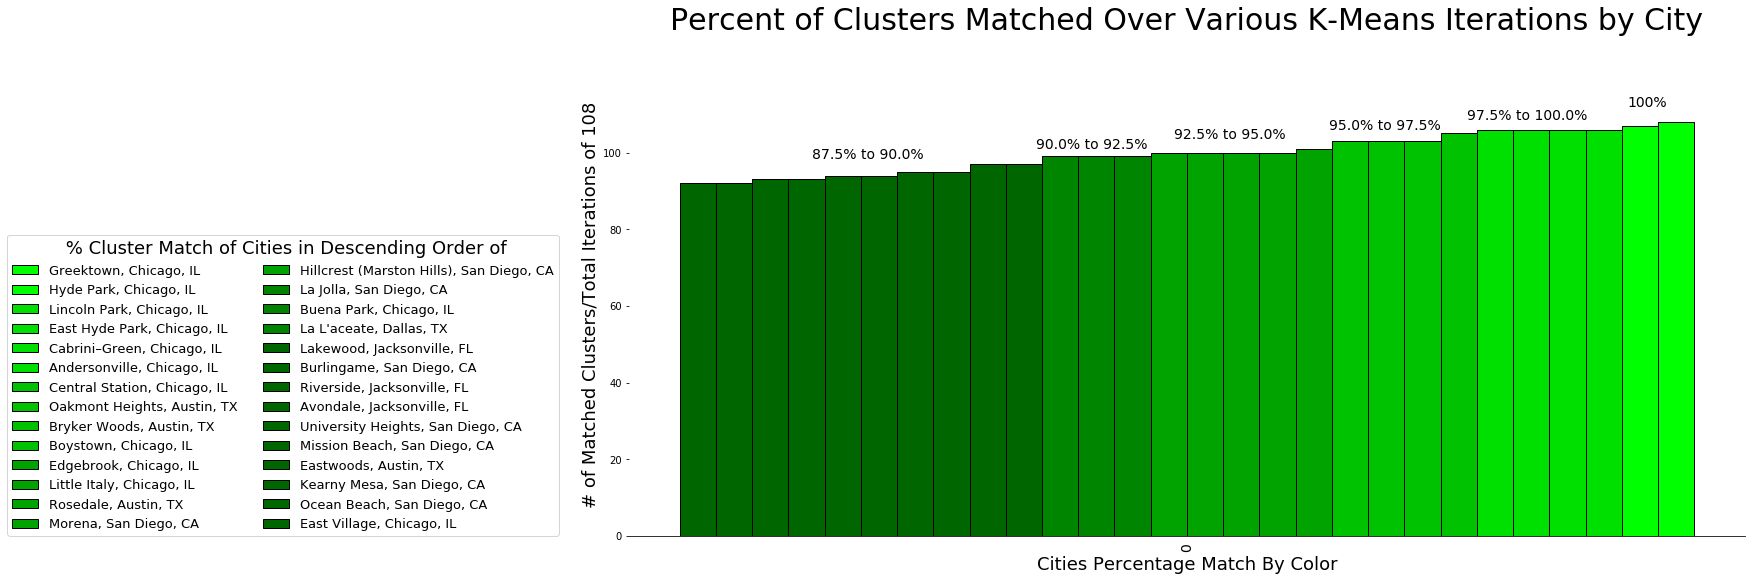

In [377]:
#Prepare for unstacked bar plot using artists layer.

# This plot will show the percentage of time each city showed up in the predictive KMeans
# Cluster. The plot is for those that appeared 87.5% or more which is 58 of 72 total 
# output clusters or greater.

ax = test_frame.plot(
    kind='bar',
    figsize=(20, 8),
    stacked=False,
    color=colors_plt,
    width=5,
    edgecolor=['black']*len(test_frame))

#Turn of spines of plot off on all side.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

#Plot annotation locations for percentages above bars.

i = -2.7     # Adjustment to center bar annotations
j=0          # Counter to obtain appropriate annot_list item

values_series_set=[87.5, 90.0, 92.5, 95.0, 97.5, 100] # List for annotation values
# Loop to find x and Y values for barplot annotations above bars
for items in values_series_set:
    if items != 100.0:
        plt.annotate(str(items)+'%'+' to '+str(items+2.5)+'%',
                     xy = (i+((annot_list[j]/2.)*.17),
                           items+11),
                     fontsize=14)
        i = (i + annot_list[j]*.17)
        j+=1
    else:   # For 100% value
        plt.annotate(str(items)+'%',
                     xy = (i+.25+((annot_list[j]/2.)*.2),
                           items+12),
                     fontsize=14)
        i = (i + annot_list[j]*.2)
        j+=1

#Set Tick Parameters to remove any extraneous information
ax.tick_params(
    axis='x',          # Changes apply to the x-axis
    which='both',      # Both major and minor ticks are affected
    left=False,        # Ticks along the bottom edge are off
    top=False,         # Ticks along the top edge are off
    bottom=False,      # Ticks along bottom are off
    labelleft=True,
    labelsize=14)      # Set Label and font size for y-axis
                                             
#create legend setting location, font, title, title_font, and anchor
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],
          title=' % Cluster Match of Cities in Descending Order of',
          title_fontsize = 18, 
          bbox_to_anchor=(-.31, -.015),
          loc='lower center',
          ncol=2, fontsize=13, fancybox=True)

# Setting title, x-axis label, and y-axis label as well as postion
plt.title("Percent of Clusters Matched Over Various K-Means Iterations by City",
          fontsize=30, y=1.15)
plt.xlabel("Cities Percentage Match By Color",
           fontsize=18)
plt.ylabel("# of Matched Clusters/Total Iterations of 108", horizontalalignment='right',
           y=1, fontsize=18 )









<h2 align=justify style="color:green"> <ins>Demographic Analysis of Cluster Matched Data</ins></h2><br>
    <span align='justify' style="font-size:14pt">Using booleans and sorting to finale selection of cities that best fit wants and needs</span>
    

In [320]:
#Creat List pf columns and create dataframe
final_list_df = pd.DataFrame(columns_list, columns=['Neighborhood'])
final_list_df.head()


,Neighborhood
0,"East Village, Chicago, IL"
1,"Ocean Beach, San Diego, CA"
2,"Kearny Mesa, San Diego, CA"
3,"Eastwoods, Austin, TX"
4,"Mission Beach, San Diego, CA"


In [378]:
# Build a Demographics DataFrame by concatenating cities matching cluster prediction match
# Over 85%.
pd_final= pd.DataFrame(columns=chicago_filtered.columns) #DF with columns from a previous
                                                         #DF with Demographics

for i in range(len(final_list_df)):         #Iteration over cities in list
                                            #and matching with each demograpics DF then
                                            #appending to new DF.
            
    temp_df = chicago_filtered.loc[chicago_filtered['Neighborhood']==          #Chicago
                                   final_list_df['Neighborhood'][i]]
    
    pd_final = pd.concat([pd_final, temp_df])
    temp_df = austin_filtered.loc[austin_filtered['Neighborhood']==             #Austin
                                  final_list_df['Neighborhood'][i]]
    
    pd_final = pd.concat([pd_final, temp_df])
    temp_df = dallas_filtered.loc[dallas_filtered['Neighborhood']==             #Dallas
                                  final_list_df['Neighborhood'][i]]
    
    pd_final = pd.concat([pd_final, temp_df])
    temp_df = jacksonville_filtered.loc[jacksonville_filtered['Neighborhood']== #Jacksonville
                                        final_list_df['Neighborhood'][i]]
    
    pd_final = pd.concat([pd_final, temp_df])
    temp_df = sandiego_filtered.loc[sandiego_filtered['Neighborhood']==       #San Diego
                                     final_list_df['Neighborhood'][i]]
    
    pd_final = pd.concat([pd_final, temp_df])
    



,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,CostOfLivingIndex,MedianMortgageToIncomeRatio,OwnerOccupiedHomesPercent,MedianRoomsInHome,CollegeDegreePercent,ProfessionalPercent,Population,AverageHouseholdSize,MedianAge,MaleToFemaleRatio,MarriedPercent,DivorcedPercent,WhitePercent,BlackPercent,AsianPercent,HispanicEthnicityPercent
30,"East Village, Chicago, IL",41.899811,-87.672294,60622,38487,294.8,22.3,26.9,4.4,34.8,40.5,75859,2.4,30.0,109.2,38.0,8.0,40.4,10.2,1.3,45.3
22,"Ocean Beach, San Diego, CA",32.749499,-117.247035,92107,42660,356.2,27.7,37.0,3.9,42.5,44.8,27845,1.9,34.5,108.7,39.5,14.4,83.5,1.0,1.8,8.9
14,"Kearny Mesa, San Diego, CA",32.828391,-117.144123,92111,42774,213.7,24.1,52.1,4.8,25.9,35.6,47011,2.7,34.3,96.3,49.8,11.9,49.6,5.3,18.4,22.1
3,"Eastwoods, Austin, TX",30.290371,-97.726479,78705,14740,185.5,21.5,11.0,2.8,73.0,45.8,26972,2.7,21.2,140.7,13.4,2.8,69.1,2.4,15.0,10.3
4,"Mission Beach, San Diego, CA",32.770653,-117.251445,92109,45202,373.7,29.2,29.8,3.7,50.8,48.1,45834,1.9,30.9,122.6,30.7,10.9,81.5,1.3,3.0,10.3
24,"University Heights, San Diego, CA",32.757206,-117.147064,92116,35401,240.3,24.3,29.9,3.9,33.4,40.9,33068,2.0,34.3,101.1,36.6,16.7,56.3,10.3,4.4,24.3
1,"Avondale, Jacksonville, FL",30.296769,-81.710315,32205,34579,76.4,20.0,58.0,5.3,21.7,33.6,30128,2.2,35.2,88.8,47.5,15.7,71.0,20.1,2.8,3.2
4,"Riverside, Jacksonville, FL",30.312904,-81.693893,32204,23957,79.3,20.9,34.0,4.4,17.7,25.5,7733,2.3,35.9,79.6,34.1,17.2,44.7,49.6,1.9,1.0
19,"Burlingame, San Diego, CA",32.731622,-117.127946,92104,31139,200.5,26.5,26.6,3.7,24.1,34.1,47380,2.2,32.3,107.0,36.9,13.4,42.9,11.8,4.7,34.8
11,"Lakewood, Jacksonville, FL",30.263600,-81.639126,32207,35568,91.2,20.6,56.4,5.2,26.6,34.3,33773,2.2,37.2,84.7,48.9,15.5,70.1,20.8,1.9,4.6


In [357]:
#Sort Descending on 'Median Income' and Limiting COst Of Living Index to less than 400
pd_final_sorted = pd_final.sort_values('MedianIncome', ascending=False)
pd_final_sorted['CostOfLivingIndex'] = pd_final_sorted['CostOfLivingIndex'].apply(lambda x: float(x))
pd_final_sorted['MedianIncome'] = pd_final_sorted['MedianIncome'].apply(lambda x: float(x))
pd_final_sorted_coli = pd_final_sorted.loc[
    pd_final_sorted[
        'CostOfLivingIndex']<400].sort_values(
    'MedianIncome',ascending = False
).reset_index(drop=True)
pd_final_sorted_coli=pd_final_sorted_coli.loc[pd_final_sorted_coli['MedianIncome']>40000]
pd_final_sorted_coli.head()


,Neighborhood,Latitude,Longitude,Zip Code,MedianIncome,CostOfLivingIndex,MedianMortgageToIncomeRatio,OwnerOccupiedHomesPercent,MedianRoomsInHome,CollegeDegreePercent,ProfessionalPercent,Population,AverageHouseholdSize,MedianAge,MaleToFemaleRatio,MarriedPercent,DivorcedPercent,WhitePercent,BlackPercent,AsianPercent,HispanicEthnicityPercent
0,"Lincoln Park, Chicago, IL",41.925470,-87.648778,60614,68324.0,383.3,18.0,40.3,3.9,78.4,66.1,65438,1.7,31.0,97.2,34.7,7.5,85.1,4.1,3.6,5.3
1,"Oakmont Heights, Austin, TX",30.311722,-97.754573,78731,62404.0,275.7,22.3,59.3,5.4,71.1,65.6,24068,2.0,37.4,94.6,51.7,9.7,84.9,0.8,6.1,6.7
2,"Edgebrook, Chicago, IL",41.997342,-87.762172,60646,58232.0,268.6,24.4,76.6,5.8,37.1,41.7,27057,2.4,42.3,85.1,59.4,6.2,84.4,0.5,6.7,6.7
3,"Central Station, Chicago, IL",41.864608,-87.621538,60605,56151.0,243.7,19.9,42.7,3.3,58.3,63.6,12688,1.8,35.2,109.7,39.9,11.6,53.3,30.7,7.9,4.4
4,"Boystown, Chicago, IL",41.943998,-87.647385,60657,55647.0,306.2,20.1,30.3,3.9,72.7,63.9,66828,1.6,30.9,104.0,29.0,7.2,82.3,3.4,5.0,7.5


In [355]:
full_pd=pd.DataFrame()
for i in range(len(pd_final_sorted_coli)):
                  pd_temp =  venues_merged.loc[
                      venues_merged['Neighborhood']== pd_final_sorted_coli['Neighborhood'][i]
                  ]
                  full_pd = pd.concat([full_pd, pd_temp])
full_pd.reset_index(drop=True, inplace=True)
full_pd.head()


,Cluster Labels,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Lincoln Park, Chicago, IL",41.925470,-87.648778,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Hot Dog Joint,Music Venue,Italian Restaurant,Cosmetics Shop,Theater,Bar
1,1,"Oakmont Heights, Austin, TX",30.311722,-97.754573,Park,Sandwich Place,Italian Restaurant,Coffee Shop,Café,Bridal Shop,Pool,Flower Shop,Bakery,Bank
2,1,"Edgebrook, Chicago, IL",41.997342,-87.762172,Hobby Shop,Sandwich Place,Spa,Ice Cream Shop,Grocery Store,Coffee Shop,Park,Restaurant,Diner,Salon / Barbershop
3,1,"Central Station, Chicago, IL",41.864608,-87.621538,History Museum,Football Stadium,Aquarium,Park,Burger Joint,Dog Run,Museum,Sushi Restaurant,Historic Site,Coffee Shop
4,1,"Boystown, Chicago, IL",41.943998,-87.647385,Gay Bar,Pizza Place,Mexican Restaurant,Sandwich Place,Pub,Japanese Restaurant,Gym,Spa,Sushi Restaurant,Coffee Shop


In [374]:
#Clean Up Dataframe
final_pd = pd.merge(full_pd, pd_final_sorted_coli, left_index=True, right_index=True)
final_pd.drop(['Cluster Labels', 'Neighborhood_y', 'Latitude_y', 'Longitude_y'], axis=1, inplace=True)
final_pd.rename(columns={'Neighborhood_x':'Neighborhood', 'Latitude_x':'Latitude', 'Longitude_x':'Longitude'}, inplace=True)
final_pd.head()


,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Zip Code,MedianIncome,CostOfLivingIndex,MedianMortgageToIncomeRatio,OwnerOccupiedHomesPercent,MedianRoomsInHome,CollegeDegreePercent,ProfessionalPercent,Population,AverageHouseholdSize,MedianAge,MaleToFemaleRatio,MarriedPercent,DivorcedPercent,WhitePercent,BlackPercent,AsianPercent,HispanicEthnicityPercent
0,"Lincoln Park, Chicago, IL",41.925470,-87.648778,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Hot Dog Joint,Music Venue,Italian Restaurant,Cosmetics Shop,Theater,Bar,60614,68324.0,383.3,18.0,40.3,3.9,78.4,66.1,65438,1.7,31.0,97.2,34.7,7.5,85.1,4.1,3.6,5.3
1,"Oakmont Heights, Austin, TX",30.311722,-97.754573,Park,Sandwich Place,Italian Restaurant,Coffee Shop,Café,Bridal Shop,Pool,Flower Shop,Bakery,Bank,78731,62404.0,275.7,22.3,59.3,5.4,71.1,65.6,24068,2.0,37.4,94.6,51.7,9.7,84.9,0.8,6.1,6.7
2,"Edgebrook, Chicago, IL",41.997342,-87.762172,Hobby Shop,Sandwich Place,Spa,Ice Cream Shop,Grocery Store,Coffee Shop,Park,Restaurant,Diner,Salon / Barbershop,60646,58232.0,268.6,24.4,76.6,5.8,37.1,41.7,27057,2.4,42.3,85.1,59.4,6.2,84.4,0.5,6.7,6.7
3,"Central Station, Chicago, IL",41.864608,-87.621538,History Museum,Football Stadium,Aquarium,Park,Burger Joint,Dog Run,Museum,Sushi Restaurant,Historic Site,Coffee Shop,60605,56151.0,243.7,19.9,42.7,3.3,58.3,63.6,12688,1.8,35.2,109.7,39.9,11.6,53.3,30.7,7.9,4.4
4,"Boystown, Chicago, IL",41.943998,-87.647385,Gay Bar,Pizza Place,Mexican Restaurant,Sandwich Place,Pub,Japanese Restaurant,Gym,Spa,Sushi Restaurant,Coffee Shop,60657,55647.0,306.2,20.1,30.3,3.9,72.7,63.9,66828,1.6,30.9,104.0,29.0,7.2,82.3,3.4,5.0,7.5


In [375]:
#Rename Columns
final_pd.rename(columns={'Neighborhood_x':'Neighborhood', 'Latitude_x':'Latitude', 'Longitude_x':'Longitude'})

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Zip Code,MedianIncome,CostOfLivingIndex,MedianMortgageToIncomeRatio,OwnerOccupiedHomesPercent,MedianRoomsInHome,CollegeDegreePercent,ProfessionalPercent,Population,AverageHouseholdSize,MedianAge,MaleToFemaleRatio,MarriedPercent,DivorcedPercent,WhitePercent,BlackPercent,AsianPercent,HispanicEthnicityPercent
0,"Lincoln Park, Chicago, IL",41.925470,-87.648778,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Hot Dog Joint,Music Venue,Italian Restaurant,Cosmetics Shop,Theater,Bar,60614,68324.0,383.3,18.0,40.3,3.9,78.4,66.1,65438,1.7,31.0,97.2,34.7,7.5,85.1,4.1,3.6,5.3
1,"Oakmont Heights, Austin, TX",30.311722,-97.754573,Park,Sandwich Place,Italian Restaurant,Coffee Shop,Café,Bridal Shop,Pool,Flower Shop,Bakery,Bank,78731,62404.0,275.7,22.3,59.3,5.4,71.1,65.6,24068,2.0,37.4,94.6,51.7,9.7,84.9,0.8,6.1,6.7
2,"Edgebrook, Chicago, IL",41.997342,-87.762172,Hobby Shop,Sandwich Place,Spa,Ice Cream Shop,Grocery Store,Coffee Shop,Park,Restaurant,Diner,Salon / Barbershop,60646,58232.0,268.6,24.4,76.6,5.8,37.1,41.7,27057,2.4,42.3,85.1,59.4,6.2,84.4,0.5,6.7,6.7
3,"Central Station, Chicago, IL",41.864608,-87.621538,History Museum,Football Stadium,Aquarium,Park,Burger Joint,Dog Run,Museum,Sushi Restaurant,Historic Site,Coffee Shop,60605,56151.0,243.7,19.9,42.7,3.3,58.3,63.6,12688,1.8,35.2,109.7,39.9,11.6,53.3,30.7,7.9,4.4
4,"Boystown, Chicago, IL",41.943998,-87.647385,Gay Bar,Pizza Place,Mexican Restaurant,Sandwich Place,Pub,Japanese Restaurant,Gym,Spa,Sushi Restaurant,Coffee Shop,60657,55647.0,306.2,20.1,30.3,3.9,72.7,63.9,66828,1.6,30.9,104.0,29.0,7.2,82.3,3.4,5.0,7.5
5,"Greektown, Chicago, IL",41.878564,-87.647050,Coffee Shop,Greek Restaurant,Italian Restaurant,New American Restaurant,Pizza Place,Sandwich Place,Café,Bar,Breakfast Spot,Mexican Restaurant,60661,54698.0,253.6,20.3,21.8,2.6,72.4,72.1,4190,1.5,32.0,121.1,39.0,11.6,56.2,23.8,14.1,4.3
6,"Bryker Woods, Austin, TX",30.302450,-97.753893,Park,American Restaurant,Gas Station,Grocery Store,Italian Restaurant,Sandwich Place,Coffee Shop,Pharmacy,Yoga Studio,Sushi Restaurant,78703,54591.0,326.0,21.1,51.5,4.8,74.1,68.1,19522,2.0,34.5,97.7,50.4,9.7,81.7,1.5,6.8,7.6
7,"Cabrini–Green, Chicago, IL",41.901091,-87.641464,Coffee Shop,Pizza Place,Gym,Gym / Fitness Center,Deli / Bodega,Sandwich Place,Food Truck,Restaurant,Nail Salon,Martial Arts Dojo,60610,51294.0,278.0,18.8,36.8,3.1,63.5,59.6,47619,1.6,34.0,87.8,32.7,10.8,63.3,26.6,4.1,3.9
8,"Buena Park, Chicago, IL",41.957676,-87.650714,Coffee Shop,Bar,Mexican Restaurant,Park,Asian Restaurant,Sandwich Place,Bank,Convenience Store,Thai Restaurant,Golf Course,60613,48381.0,232.3,20.7,33.2,3.8,61.1,57.0,50608,1.7,32.3,106.6,30.2,8.7,70.6,7.9,5.5,13.0
9,"Mission Beach, San Diego, CA",32.770653,-117.251445,Beach,Bar,Park,Taco Place,Harbor / Marina,Pizza Place,Sandwich Place,Sushi Restaurant,Coffee Shop,Clothing Store,92109,45202.0,373.7,29.2,29.8,3.7,50.8,48.1,45834,1.9,30.9,122.6,30.7,10.9,81.5,1.3,3.0,10.3


In [376]:
#Rearrange Dataframe
columns_list_2 = []
columns_list = list(final_pd.columns)
columns_list_2.append(columns_list[0])
columns_list_2.append(columns_list[13:16])
columns_list_2.append(columns_list[3:13])
columns_list_2.append(columns_list[16:])
columns_list_2.append(columns_list[1:3])
new_column_list = [item for items in columns_list_2[1:] for item in items]
new_column_list.insert(0,columns_list[0])
final_pd = final_pd[new_column_list]
final_pd


,Neighborhood,Zip Code,MedianIncome,CostOfLivingIndex,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,MedianMortgageToIncomeRatio,OwnerOccupiedHomesPercent,MedianRoomsInHome,CollegeDegreePercent,ProfessionalPercent,Population,AverageHouseholdSize,MedianAge,MaleToFemaleRatio,MarriedPercent,DivorcedPercent,WhitePercent,BlackPercent,AsianPercent,HispanicEthnicityPercent,Latitude,Longitude
0,"Lincoln Park, Chicago, IL",60614,68324.0,383.3,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Hot Dog Joint,Music Venue,Italian Restaurant,Cosmetics Shop,Theater,Bar,18.0,40.3,3.9,78.4,66.1,65438,1.7,31.0,97.2,34.7,7.5,85.1,4.1,3.6,5.3,41.925470,-87.648778
1,"Oakmont Heights, Austin, TX",78731,62404.0,275.7,Park,Sandwich Place,Italian Restaurant,Coffee Shop,Café,Bridal Shop,Pool,Flower Shop,Bakery,Bank,22.3,59.3,5.4,71.1,65.6,24068,2.0,37.4,94.6,51.7,9.7,84.9,0.8,6.1,6.7,30.311722,-97.754573
2,"Edgebrook, Chicago, IL",60646,58232.0,268.6,Hobby Shop,Sandwich Place,Spa,Ice Cream Shop,Grocery Store,Coffee Shop,Park,Restaurant,Diner,Salon / Barbershop,24.4,76.6,5.8,37.1,41.7,27057,2.4,42.3,85.1,59.4,6.2,84.4,0.5,6.7,6.7,41.997342,-87.762172
3,"Central Station, Chicago, IL",60605,56151.0,243.7,History Museum,Football Stadium,Aquarium,Park,Burger Joint,Dog Run,Museum,Sushi Restaurant,Historic Site,Coffee Shop,19.9,42.7,3.3,58.3,63.6,12688,1.8,35.2,109.7,39.9,11.6,53.3,30.7,7.9,4.4,41.864608,-87.621538
4,"Boystown, Chicago, IL",60657,55647.0,306.2,Gay Bar,Pizza Place,Mexican Restaurant,Sandwich Place,Pub,Japanese Restaurant,Gym,Spa,Sushi Restaurant,Coffee Shop,20.1,30.3,3.9,72.7,63.9,66828,1.6,30.9,104.0,29.0,7.2,82.3,3.4,5.0,7.5,41.943998,-87.647385
5,"Greektown, Chicago, IL",60661,54698.0,253.6,Coffee Shop,Greek Restaurant,Italian Restaurant,New American Restaurant,Pizza Place,Sandwich Place,Café,Bar,Breakfast Spot,Mexican Restaurant,20.3,21.8,2.6,72.4,72.1,4190,1.5,32.0,121.1,39.0,11.6,56.2,23.8,14.1,4.3,41.878564,-87.647050
6,"Bryker Woods, Austin, TX",78703,54591.0,326.0,Park,American Restaurant,Gas Station,Grocery Store,Italian Restaurant,Sandwich Place,Coffee Shop,Pharmacy,Yoga Studio,Sushi Restaurant,21.1,51.5,4.8,74.1,68.1,19522,2.0,34.5,97.7,50.4,9.7,81.7,1.5,6.8,7.6,30.302450,-97.753893
7,"Cabrini–Green, Chicago, IL",60610,51294.0,278.0,Coffee Shop,Pizza Place,Gym,Gym / Fitness Center,Deli / Bodega,Sandwich Place,Food Truck,Restaurant,Nail Salon,Martial Arts Dojo,18.8,36.8,3.1,63.5,59.6,47619,1.6,34.0,87.8,32.7,10.8,63.3,26.6,4.1,3.9,41.901091,-87.641464
8,"Buena Park, Chicago, IL",60613,48381.0,232.3,Coffee Shop,Bar,Mexican Restaurant,Park,Asian Restaurant,Sandwich Place,Bank,Convenience Store,Thai Restaurant,Golf Course,20.7,33.2,3.8,61.1,57.0,50608,1.7,32.3,106.6,30.2,8.7,70.6,7.9,5.5,13.0,41.957676,-87.650714
9,"Mission Beach, San Diego, CA",92109,45202.0,373.7,Beach,Bar,Park,Taco Place,Harbor / Marina,Pizza Place,Sandwich Place,Sushi Restaurant,Coffee Shop,Clothing Store,29.2,29.8,3.7,50.8,48.1,45834,1.9,30.9,122.6,30.7,10.9,81.5,1.3,3.0,10.3,32.770653,-117.251445


<h2 align=justify style="color:green"> <ins>Mapping of Matched Neighborhoods</ins></h2><br>
    <span align='justify' style="font-size:14pt">Use Folium to matched final cities in Dataframe</span>
    

<span style="font-size:16pt; color:red"><ins>San Diego, CA Neighborhood Map:</ins></span><br>
<span style="font-size:14pt; color:black">Ideal Neighborhoods</span>

In [400]:
#Scaled down function for local clustering of ideal neighborhoods.
def ideal_folium_map(latitude, longitude, zoom_start):
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
    markers_colors = []
    for lat, lon, poi in zip(final_pd['Latitude'],
                                      final_pd['Longitude'],
                                      final_pd['Neighborhood']
                                      ):
        label = folium.Popup(str(poi), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=7,
            popup=label,
            color='red',
            fill=True,
            fill_color='gree',
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters


In [401]:
#Use Nominatim from Geocoders to find lonigude and laatitude of each city
address = 'San Diego, CA'
geolocator = Nominatim(user_agent = 'explorer')
location=geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates on Chicago, IL are {}, {}.'.format(latitude, longitude))


The geographical coordinates on Chicago, IL are 32.7174209, -117.1627714.


In [402]:
#Map CLusters in San Diego, CA
map_clusters = ideal_folium_map(latitude, longitude, zoom_start=11)
map_clusters


In [403]:
map_clusters.save('san_diego_ideal_map.html')

<span style="font-size:16pt; color:red"><ins>Austin, TX Neighborhood Map:</ins></span><br>
<span style="font-size:14pt; color:black">Ideal Neighborhoods</span>

In [404]:
#Use Nominatim from Geocoders to find lonigude and laatitude of each city
address = 'Austin, TX'
geolocator = Nominatim(user_agent = 'explorer')
location=geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates on Austin, TX are {}, {}.'.format(latitude, longitude))


The geographical coordinates on Austin, TX are 30.2711286, -97.7436995.


In [405]:
#Ideal Locations in Austin, TX
map_clusters = ideal_folium_map(latitude, longitude, zoom_start=11)
map_clusters


In [406]:
map_clusters.save('austin_ideal_map.html')

<span style="font-size:16pt; color:red"><ins>Chicago, IL Neighborhood Map:</ins></span><br>
<span style="font-size:14pt; color:black">Ideal Neighborhoods</span>

In [407]:
#Use Nominatim from Geocoders to find lonigude and laatitude of each city
address = 'Chicago, IL'
geolocator = Nominatim(user_agent = 'explorer')
location=geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates on Chicago, IL are {}, {}.'.format(latitude, longitude))


The geographical coordinates on Chicago, IL are 41.8755616, -87.6244212.


In [408]:
#Ideal Locations in Chicago, IL
map_clusters = ideal_folium_map(latitude, longitude, zoom_start=11)
map_clusters


In [ ]:
map_clusters.save('chicago_ideal_map.html')

<h2>Thank you very much for using our relocation Service!!!<br>
Good Luck with your Move and your future!!<br>
Sincerely Gennaro -- The Relocation Suggestion Expert!<h2>